# Import

In [1]:
import numpy as np
import pandas as pd
import sklearn.manifold
import torch
from leaspy import AlgorithmSettings, Leaspy
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import argparse
import os
import json
import matplotlib.pyplot as pl
import sklearn

from dataset.Dataset2D import Dataset2D, Dataset2D_patch
from longitudinalModel.fit_longitudinal_estimator_on_nn import fit_longitudinal_estimator_on_nn
from dataset.group_based_train_test_split import group_based_train_test_split

from nnModels.CVAE2D_ORIGINAL import CVAE2D_ORIGINAL
from nnModels.CVAE2D_PATCH import CVAE2D_PATCH
from nnModels.losses import image_reconstruction_error, pixel_reconstruction_error

from utils.display_individual_observations_2D import project_encodings_for_results
from dataset.LongitudinalDataset2D import LongitudinalDataset2D, longitudinal_collate_2D
from dataset.LongitudinalDataset2D_patch import LongitudinalDataset2D_patch, longitudinal_collate_2D_patch
device = "cuda" if torch.cuda.is_available() else "cpu"

# Functions

In [2]:
def get_longitudinal_images(data, model, fitted_longitudinal_estimator):
    encodings = []
    times = []
    ids = []
    subject_id = data[2][0]

    encoder_output = model.encoder(data[0].float().to(device))
    logvars = encoder_output[1].detach().clone().to(device)
    encodings.append(encoder_output[0].detach().clone().to(device))
    for i in range(len(data[1])):
        times.extend(data[1][i])
        ids.extend([data[2][i]] * len(data[1][i]))
    encodings = torch.cat(encodings)
    encodings_df = pd.DataFrame({'ID': ids, 'TIME': times})
    for i in range(encodings.shape[1]):
        encodings_df.insert(len(encodings_df.columns), f"ENCODING{i}",
                            encodings[:, i].detach().clone().tolist())
    encodings_df['ID'] = encodings_df['ID'].astype(str)
    projection_timepoints = {str(subject_id): data[1][0]}
    predicted_latent_variables, _ = project_encodings_for_results(encodings_df, str(subject_id),
                                                                                fitted_longitudinal_estimator,
                                                                                projection_timepoints)
    projected_images = model.decoder(torch.tensor(predicted_latent_variables[str(subject_id)]).to(device))
    return encodings, logvars, projected_images

In [3]:
def plot_figures(original_image, reconstructed_original_LVAE, anomaly_image, reconstructed_anomaly_LVAE, id, anomaly_type, show_fig=False):
    """
    We enter this function when an anomaly is detected.
    The function will plot the image and save it in a pdf file.
    """

    fig_width = original_image.shape[0] * 10
    fig_height = 50  # Adjust as needed
    f, axarr = plt.subplots(4, 10, figsize=(fig_width, fig_height))
    for i in range(original_image.shape[0]):
        axarr[0, i].imshow(original_image[i, :, :], cmap="gray")
        axarr[1, i].imshow(reconstructed_original_LVAE[i, :, :], cmap="gray")
        axarr[2, i].imshow(anomaly_image[i, :, :], cmap="gray")
        axarr[3, i].imshow(reconstructed_anomaly_LVAE[i, :, :], cmap="gray")

        # axarr[0, i].set_title(f"LVAE={detection_vector_LVAE[i]}", fontsize=50)
    
    # Row labels
    row_labels = ["Original", "Original\n reconstruction", "Anomaly", "Anomaly\n reconstruction"]
    for row in range(4):
        # Add label to the first column of each row, closer and vertically centered
        axarr[row, 0].annotate(row_labels[row],
                            xy=(-0.1, 0.5),  # Slightly to the left, centered vertically
                            xycoords='axes fraction',
                            ha='right',
                            va='center',
                            fontsize=60)

    f.suptitle(f'Individual id = {id}', fontsize=80)
    plt.tight_layout()
    if show_fig:
        plt.show()
    else:
        plt.savefig(f"visu/{id}_plot_figures_{anomaly_type}.pdf")
    plt.clf()
    return 

# Global variables

In [4]:
show_fig = True
ages_list = np.array(open("data_starmen/path_to_visit_ages_file.txt", "r").read().split()).astype(float)

# Visualise trajectory norm difference

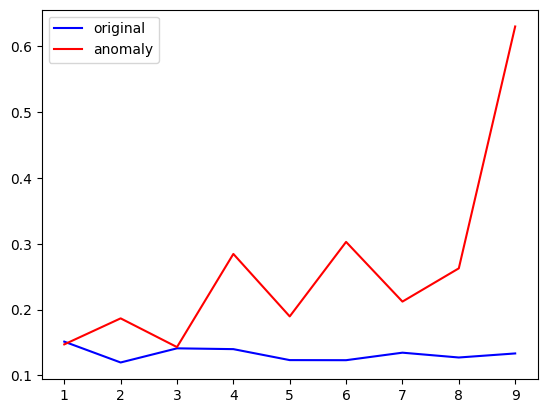

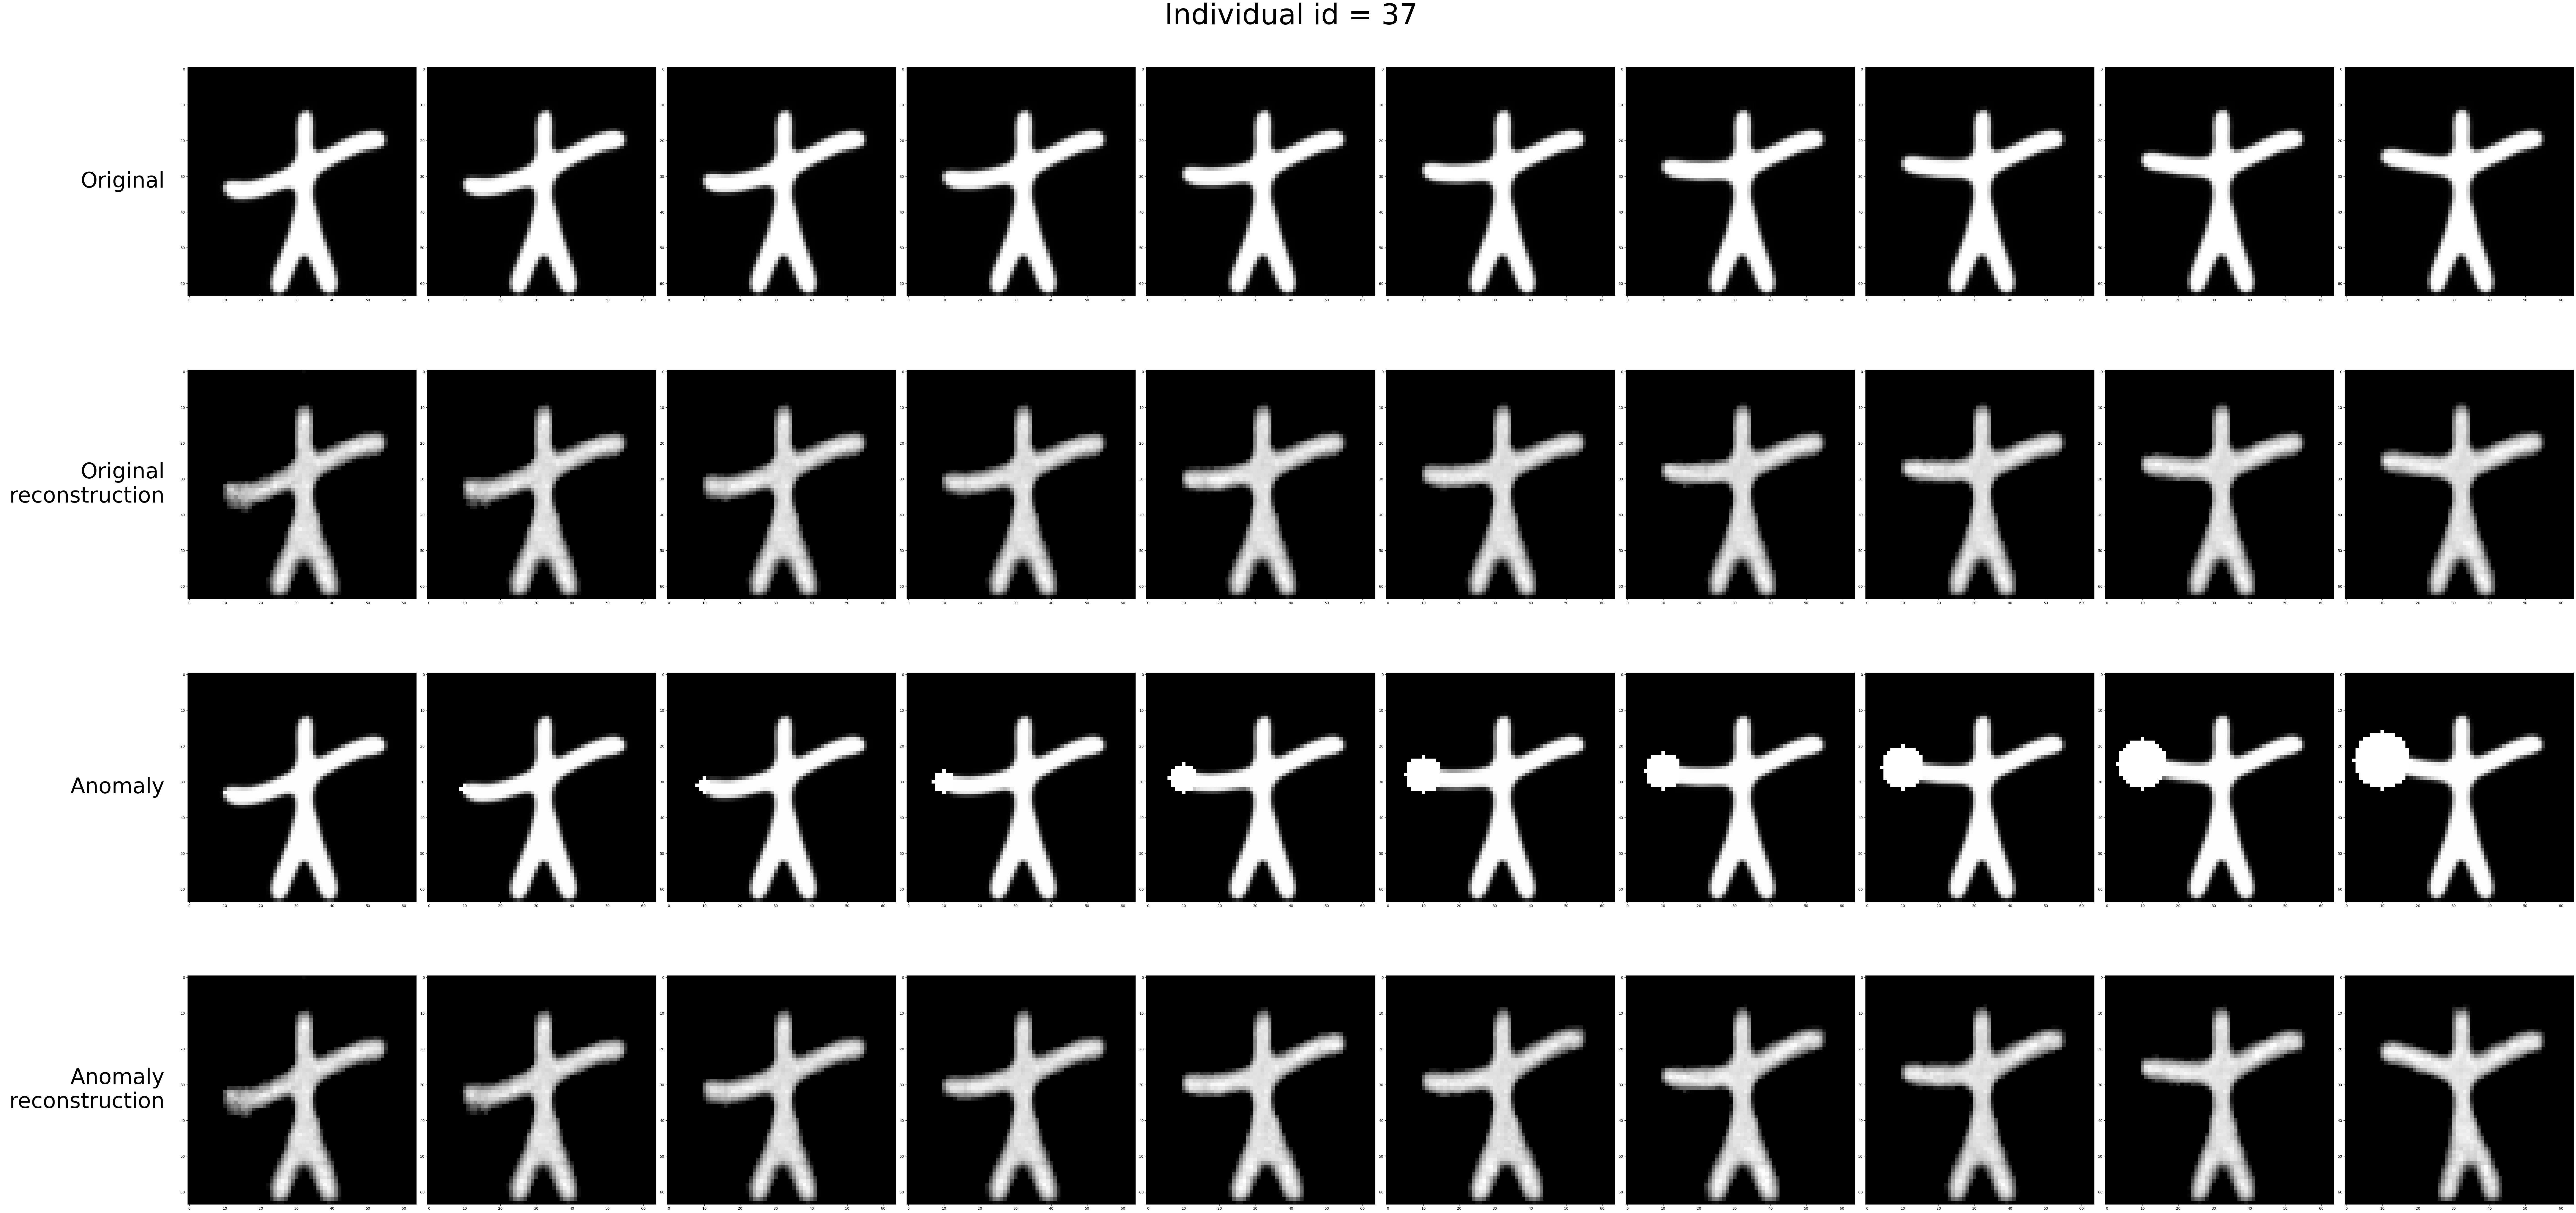

<Figure size 640x480 with 0 Axes>

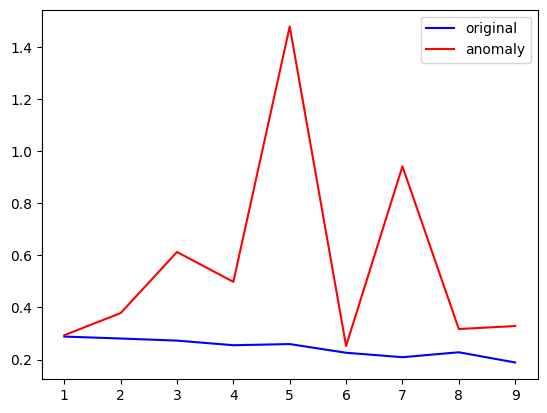

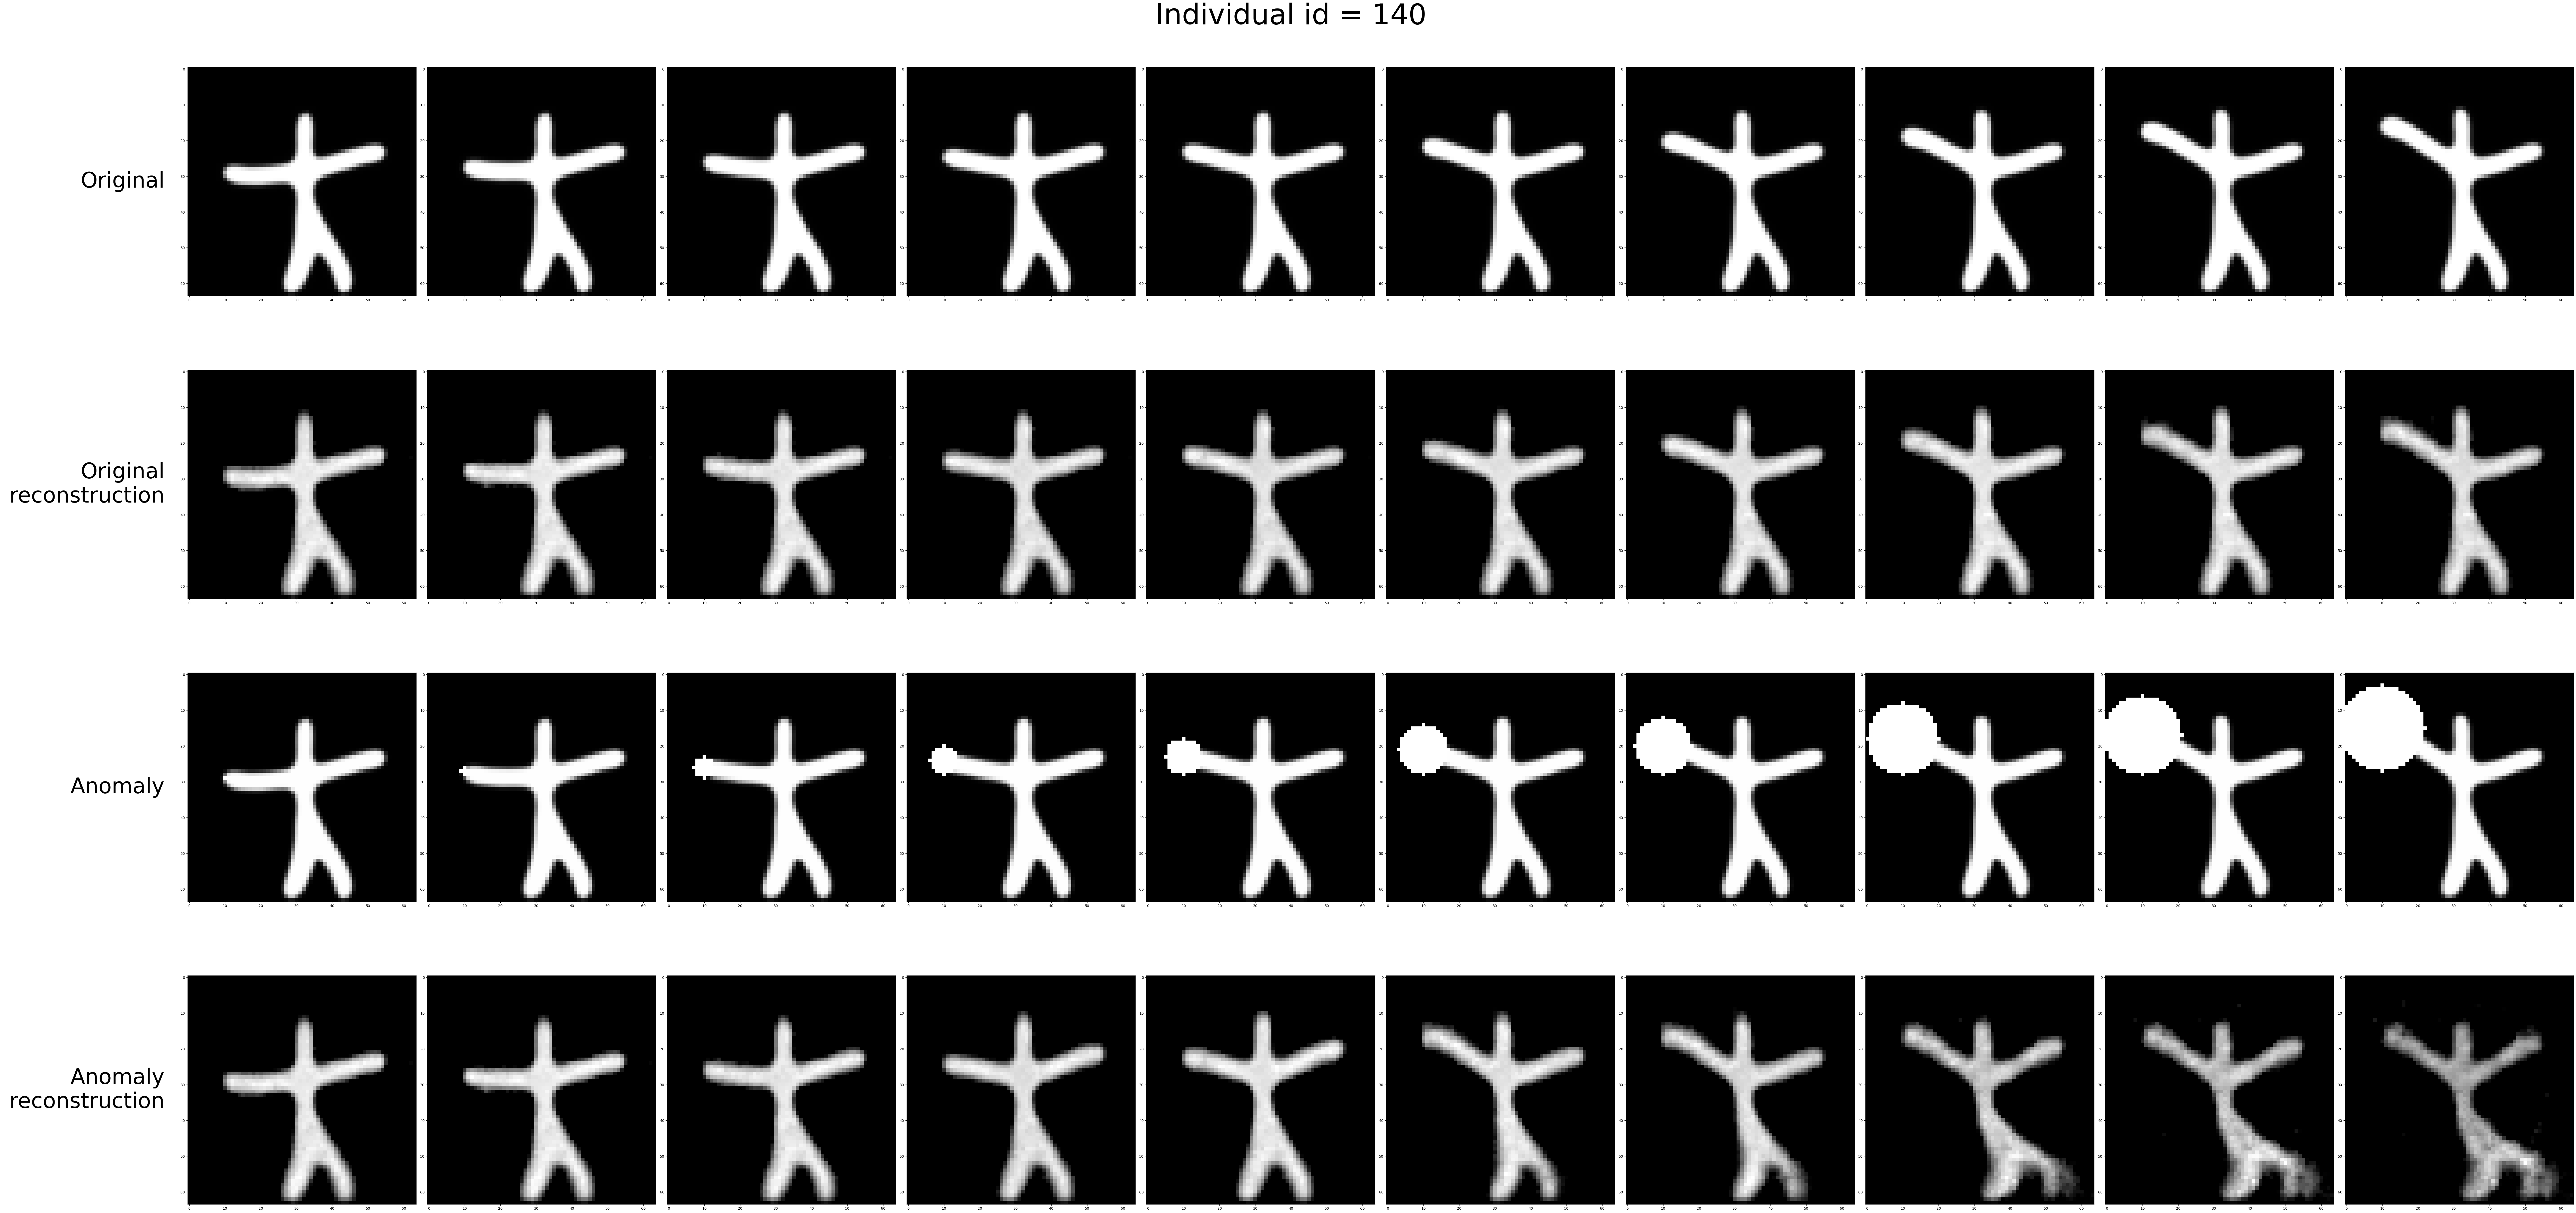

<Figure size 640x480 with 0 Axes>

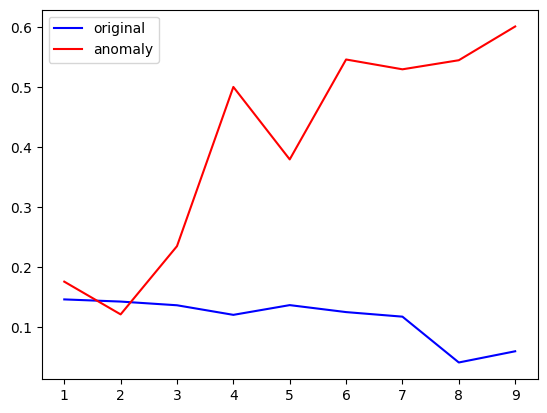

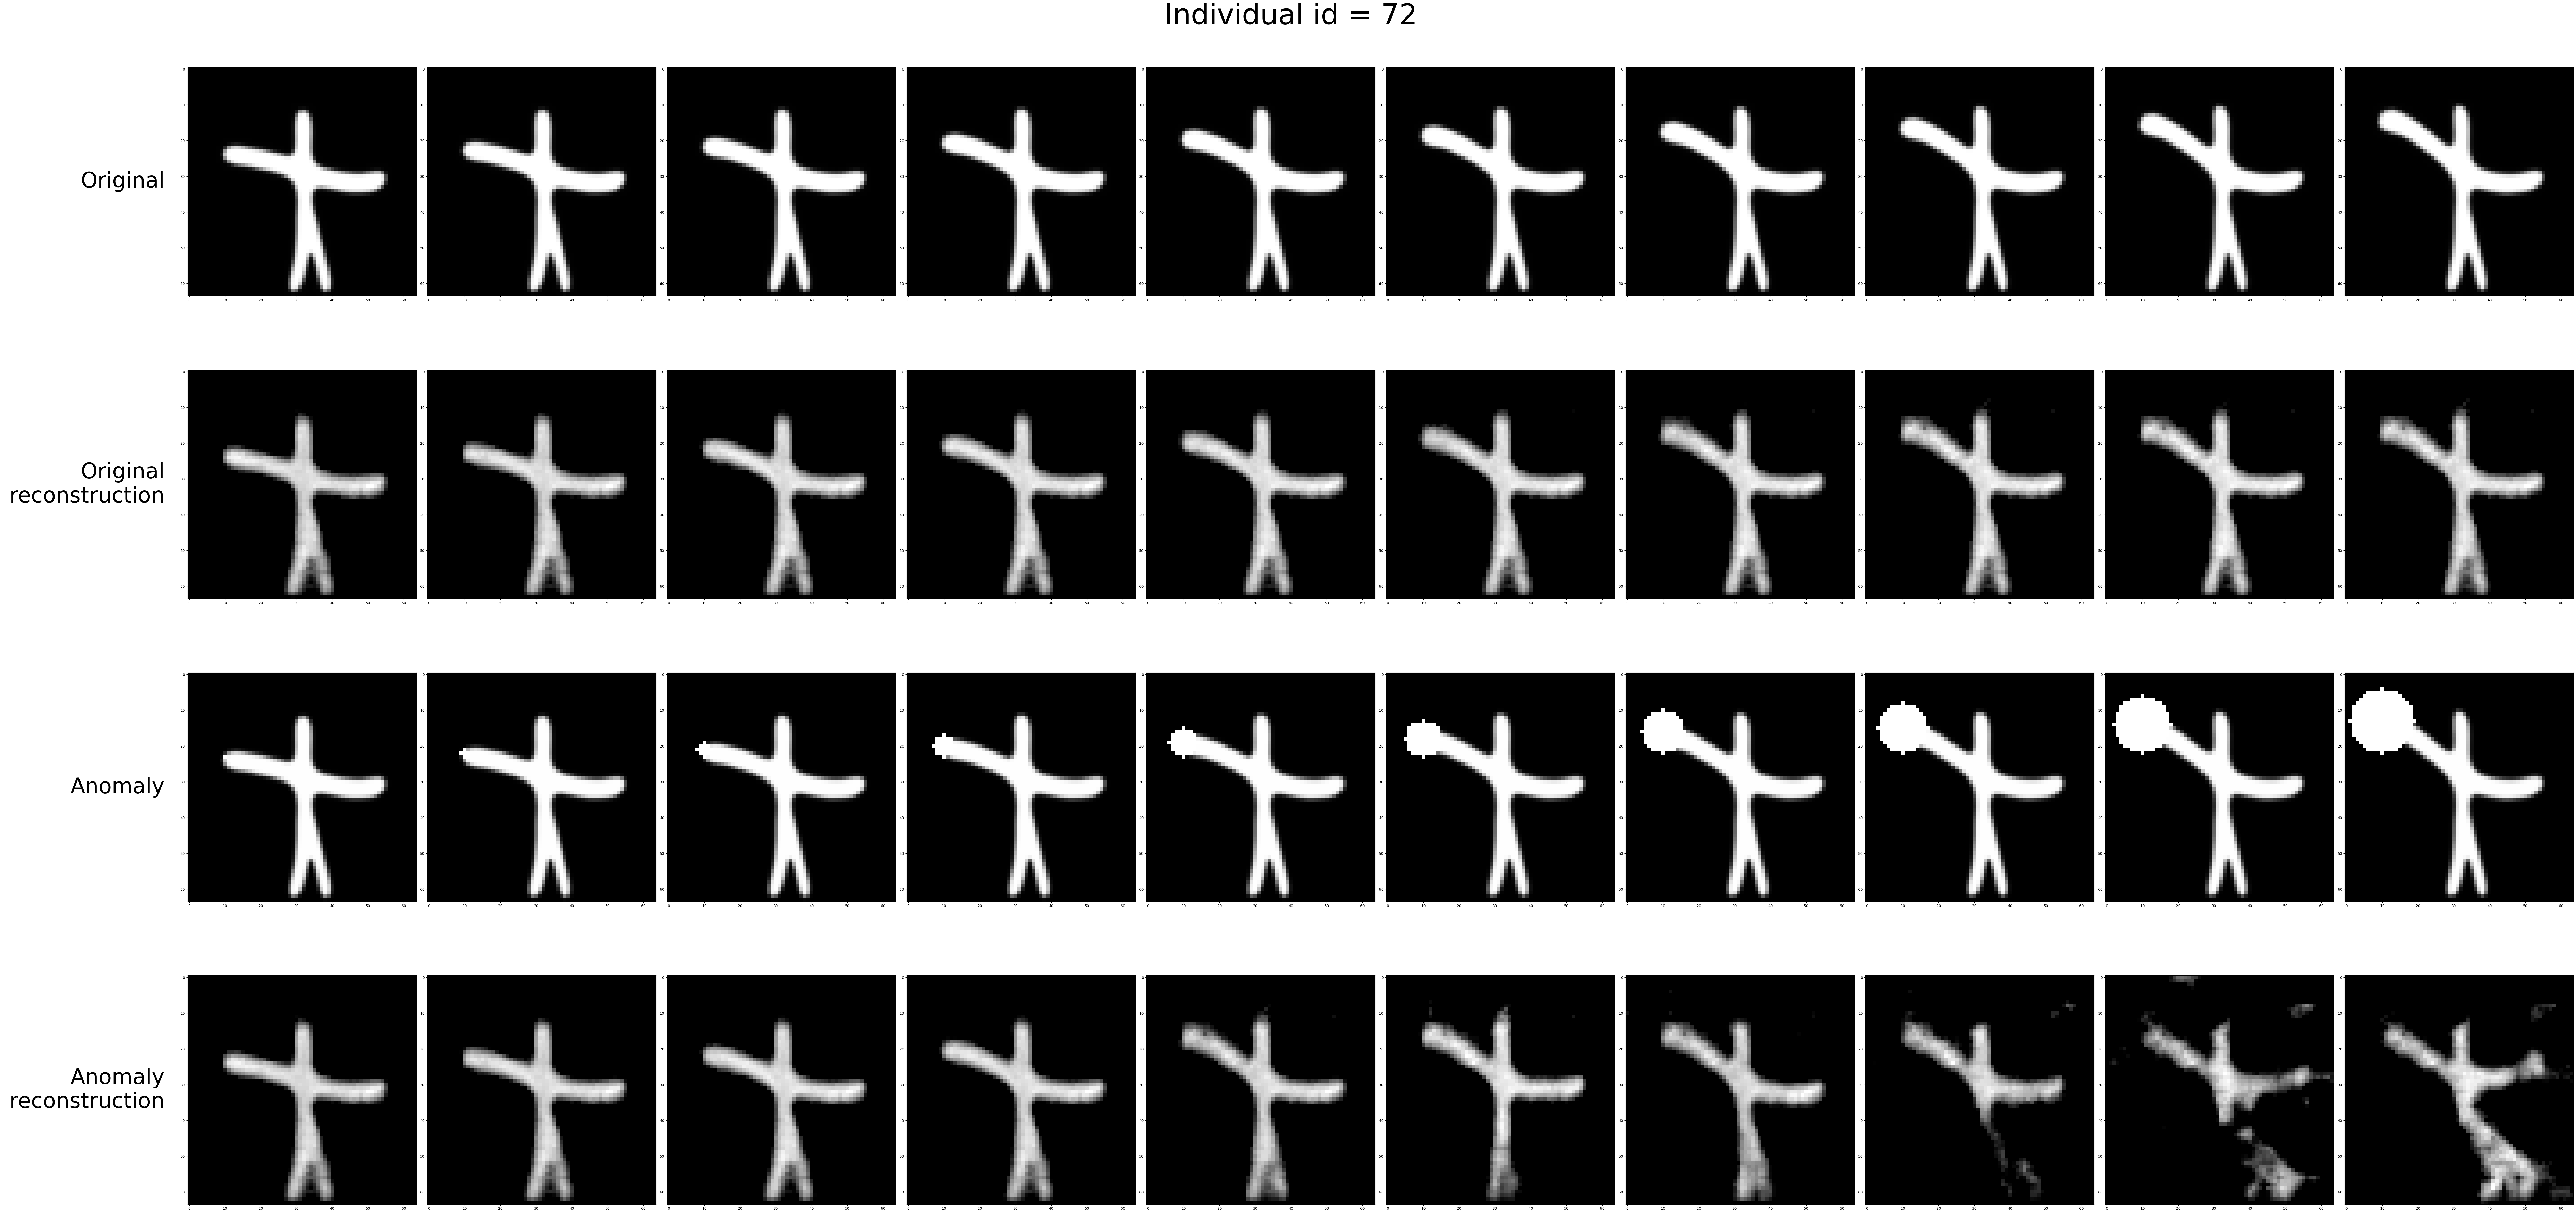

<Figure size 640x480 with 0 Axes>

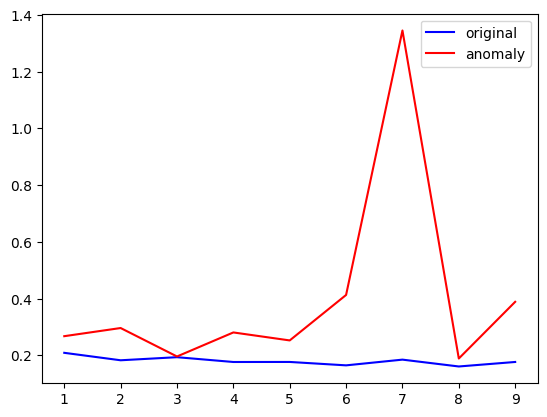

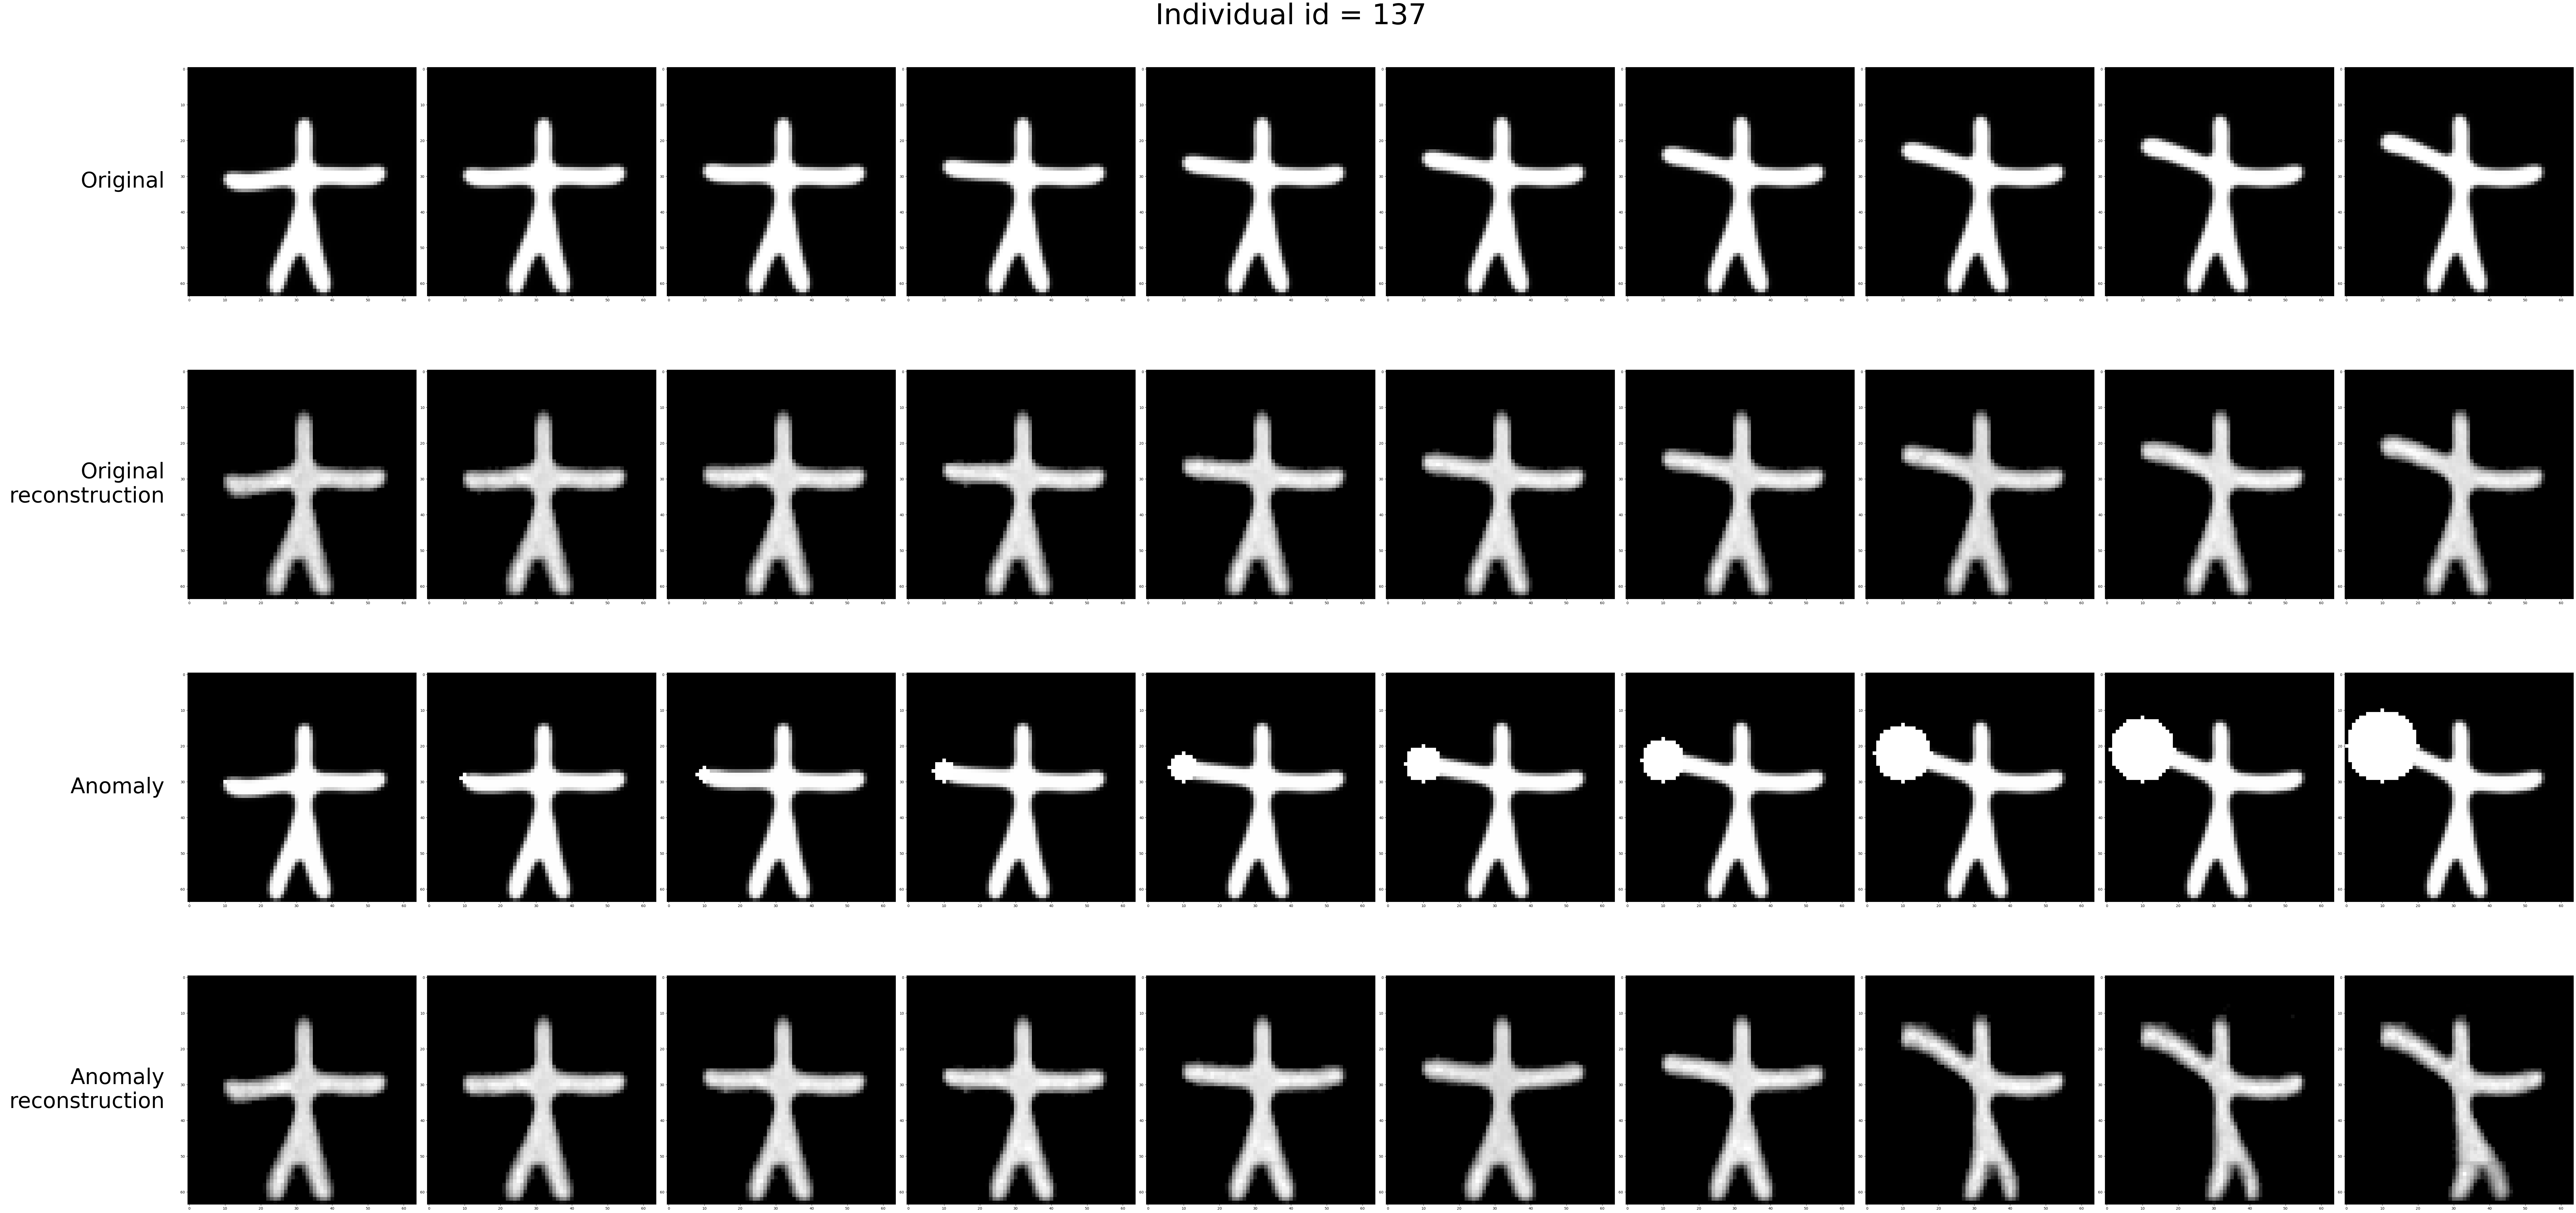

<Figure size 640x480 with 0 Axes>

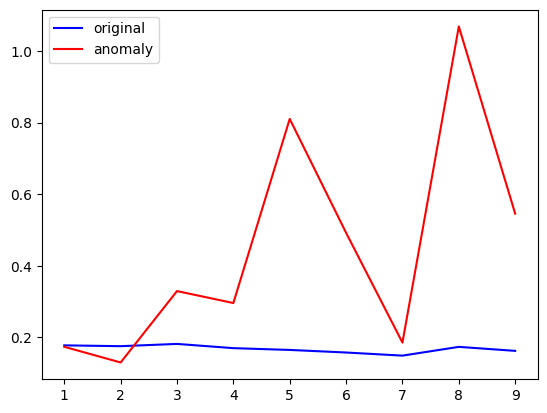

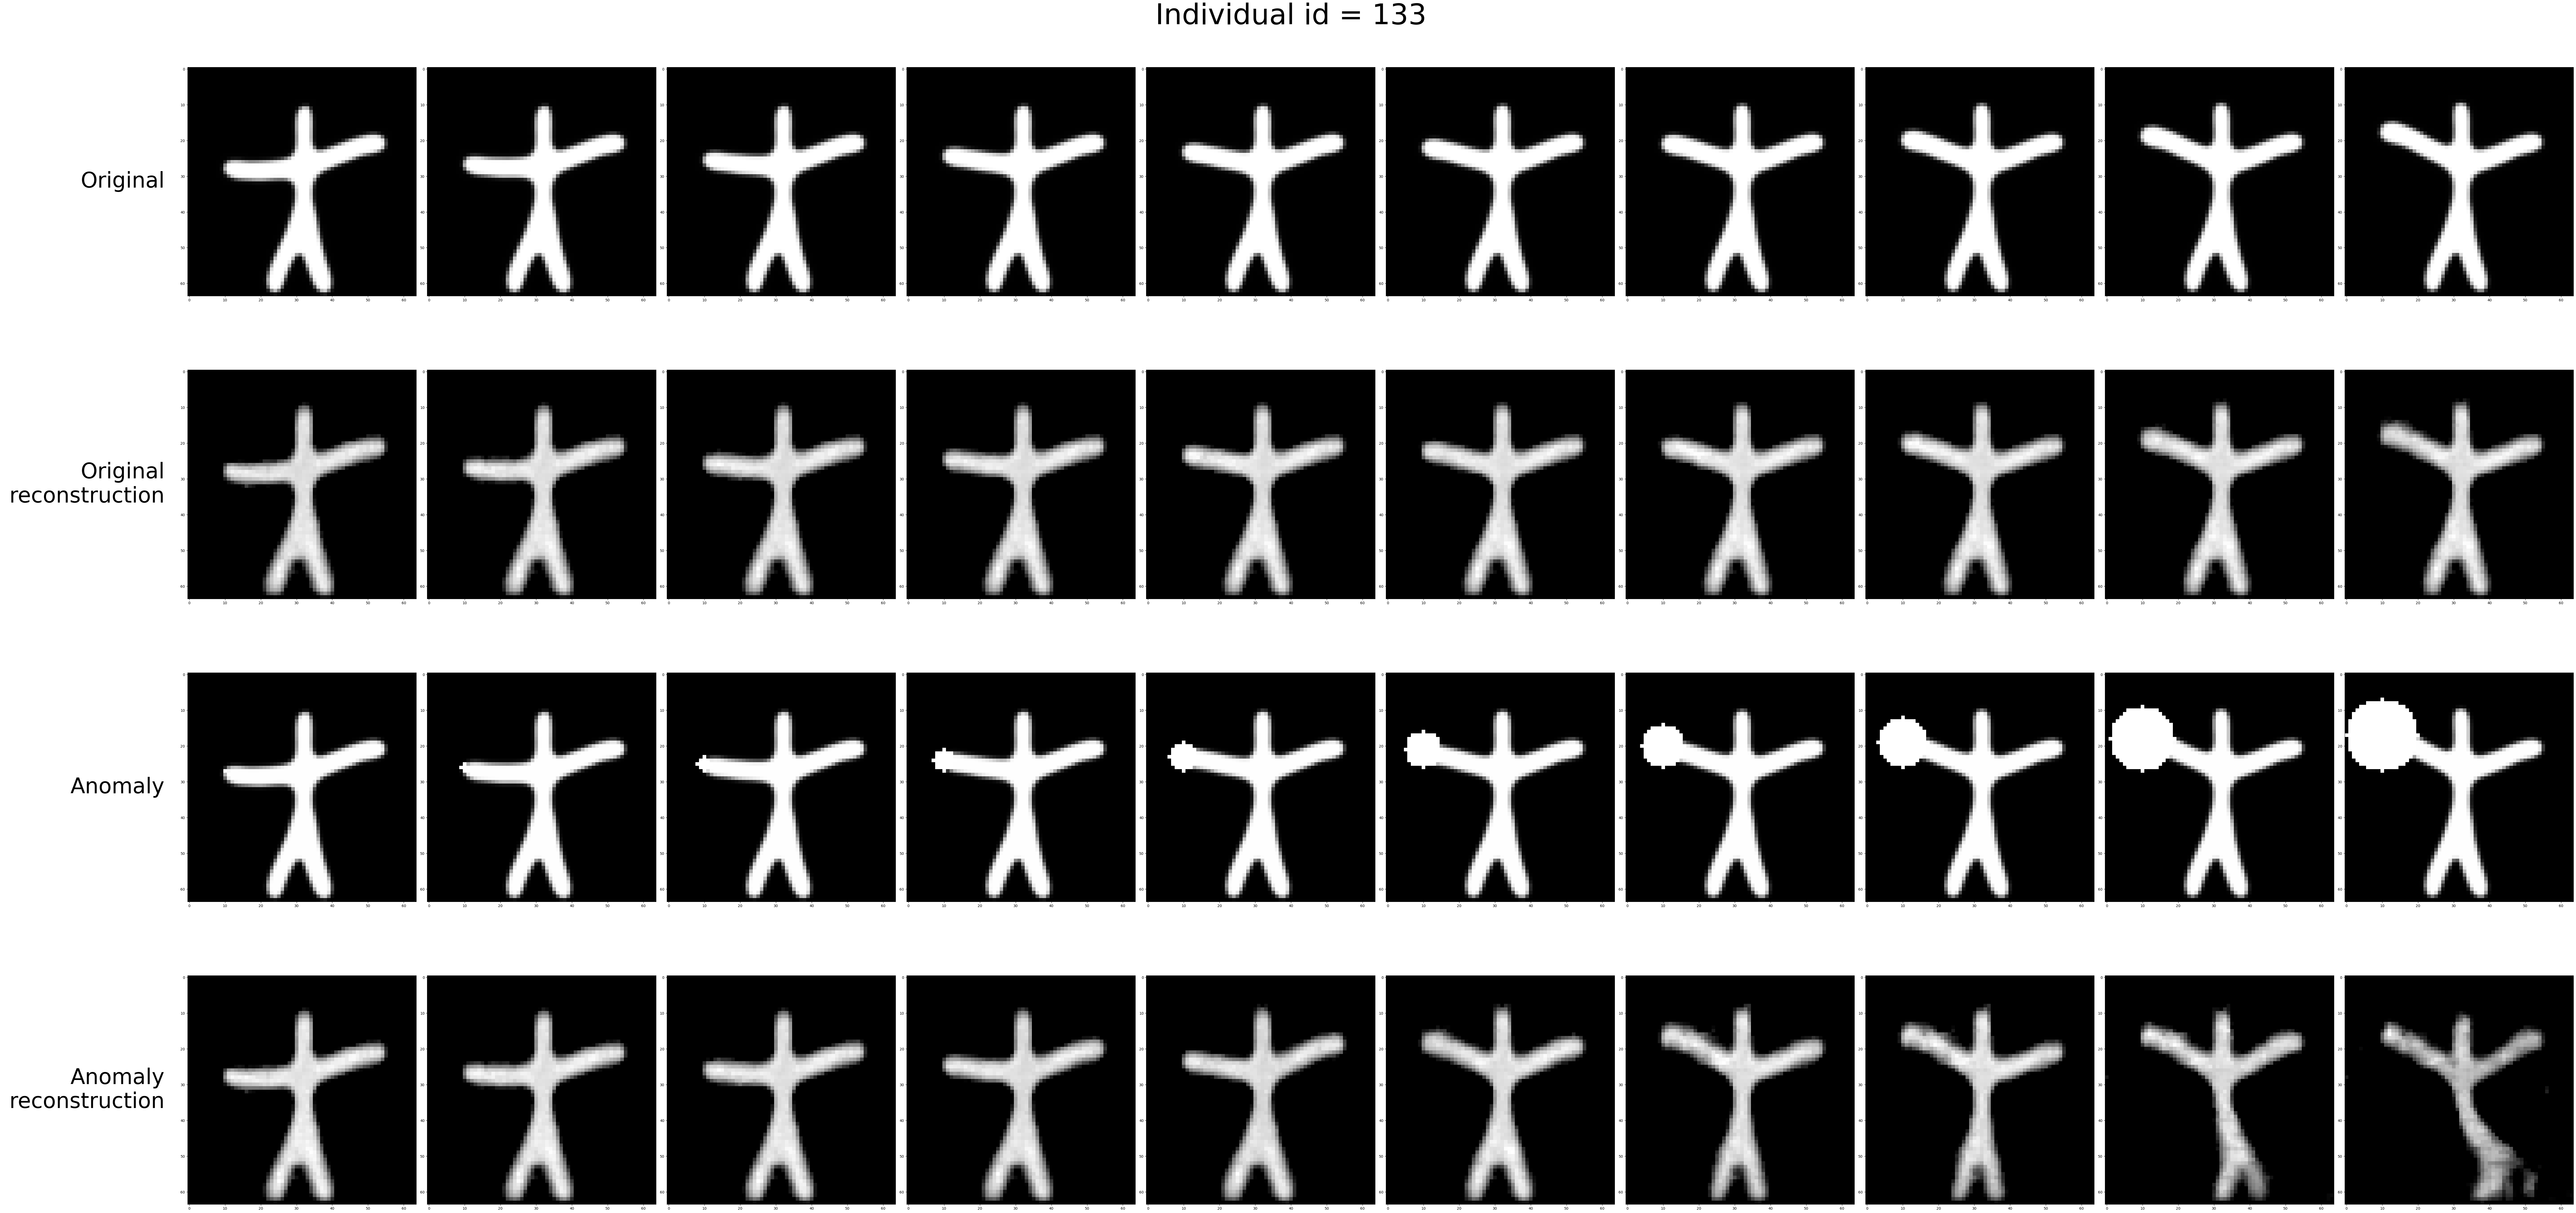

<Figure size 640x480 with 0 Axes>

In [ ]:
VAE_model_path = f"saved_models_2D/best_fold_CVAE2D_4_5.pth"
LVAE_model_path = f"saved_models_2D/best_fold_CVAE2D_4_5_100_200.pth2"
LVAE_estimator_path = f"saved_models_2Dbest_fold_longitudinal_estimator_params_CVAE2D_4_5_100_200.json2"

data_csv_path = "data_csv/starmen_test_set.csv"
dataset_test = LongitudinalDataset2D(data_csv_path)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=longitudinal_collate_2D, num_workers=round(os.cpu_count()/4))

anomaly_type = "growing_circle"
data_anomaly_csv_path = f"data_csv/anomaly_{anomaly_type}_starmen_dataset.csv"
dataset_anomaly = LongitudinalDataset2D(data_anomaly_csv_path)
dataloader_anomaly = DataLoader(dataset_anomaly, batch_size=1, shuffle=False, collate_fn=longitudinal_collate_2D, num_workers=round(os.cpu_count()/4))

model = CVAE2D_ORIGINAL(4)
model.gamma = 100
model.beta = 5
model.load_state_dict(torch.load(LVAE_model_path, map_location='cpu'))
model.to(device)
model.eval()
model.training = False

longitudinal_estimator = Leaspy.load(LVAE_estimator_path)

encodings_original_array = np.zeros((len(dataset_test), 10, 4))
encodings_anomaly_array = np.zeros((len(dataset_test), 10, 4))
n_subject = 0

image_original_array = np.zeros((len(dataset_test), 10, 64, 64))
image_original_reconstructed_array = np.zeros((len(dataset_test), 10, 64, 64))
image_anomaly_array = np.zeros((len(dataset_test), 10, 64, 64))
image_anomaly_reconstructed_array = np.zeros((len(dataset_test), 10, 64, 64))
ages_array = np.zeros((len(dataset_test), 10))

for data in dataloader_test:
    subject_id = data[2][0]
    ages_array[n_subject, :] = ages_list[subject_id*10: subject_id*10+10]
    images_original = data[0].to(device)
    images_anomaly = dataset_anomaly.get_images_from_id(subject_id)[0].reshape((10,1,64,64)).to(device)

    image_original_array[n_subject] = images_original.detach().numpy().reshape((10,64,64))
    image_anomaly_array[n_subject] = images_anomaly.detach().numpy().reshape((10,64,64))

    mus_original_LVAE, logvars_original_LVAE, reconstructed_original, _ = model(images_original)
    mus_anomaly_LVAE, logvars_original_LVAE, reconstructed_anomaly, _ = model(images_anomaly)
    
    for i in range(10):
        encodings_original_array[n_subject, i, :] = mus_original_LVAE[i].detach().numpy()
        encodings_anomaly_array[n_subject, i, :] = mus_anomaly_LVAE[i].detach().numpy()

        image_original_reconstructed_array[n_subject, i] = reconstructed_original[i].detach().numpy()
        image_anomaly_reconstructed_array[n_subject, i] = reconstructed_anomaly[i].detach().numpy()

    n_subject += 1


difference_original_norm = np.zeros((len(dataset_test), 9))
difference_anomaly_norm = np.zeros((len(dataset_test), 9))
for i in range(len(dataset_test)):
    ages_diff = ages_array[i, 1:] - ages_array[i, :-1]
    for j in range(9):
        difference_original_norm[i, j] = np.linalg.norm(encodings_original_array[i, j] - encodings_original_array[i, j+1], ord=1)
        difference_anomaly_norm[i, j] = np.linalg.norm(encodings_anomaly_array[i, j] - encodings_anomaly_array[i, j+1], ord=1)
    difference_original_norm[i, :] = difference_original_norm[i, :] * ages_diff
    difference_anomaly_norm[i, :] = difference_anomaly_norm[i, :] * ages_diff


np.random.seed(1)
random_id = np.random.choice(len(dataset_test), size=5)
for id in random_id:
    fig, ax = plt.subplots()
    ax.plot([i for i in range(1, 10)], difference_original_norm[id, :], color="blue", label="original")
    ax.plot([i for i in range(1, 10)], difference_anomaly_norm[id, :], color="red", label="anomaly")
    ax.legend()
    if show_fig:
        plt.show()
    else:
        fig.savefig(f"visu/{id}_trajectory_norm_diff_{anomaly_type}.pdf")
    plt.close(fig)
    plot_figures(image_original_array[id], image_original_reconstructed_array[id], image_anomaly_array[id], image_anomaly_reconstructed_array[id], id, anomaly_type, show_fig)


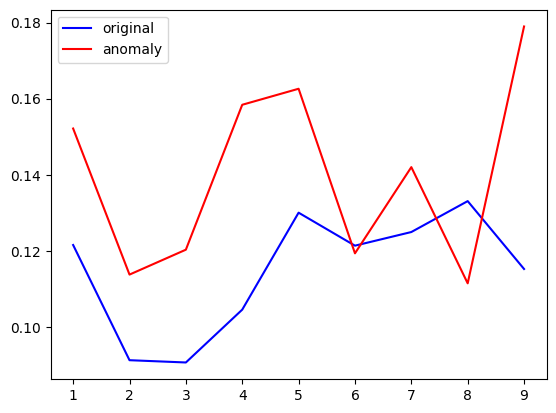

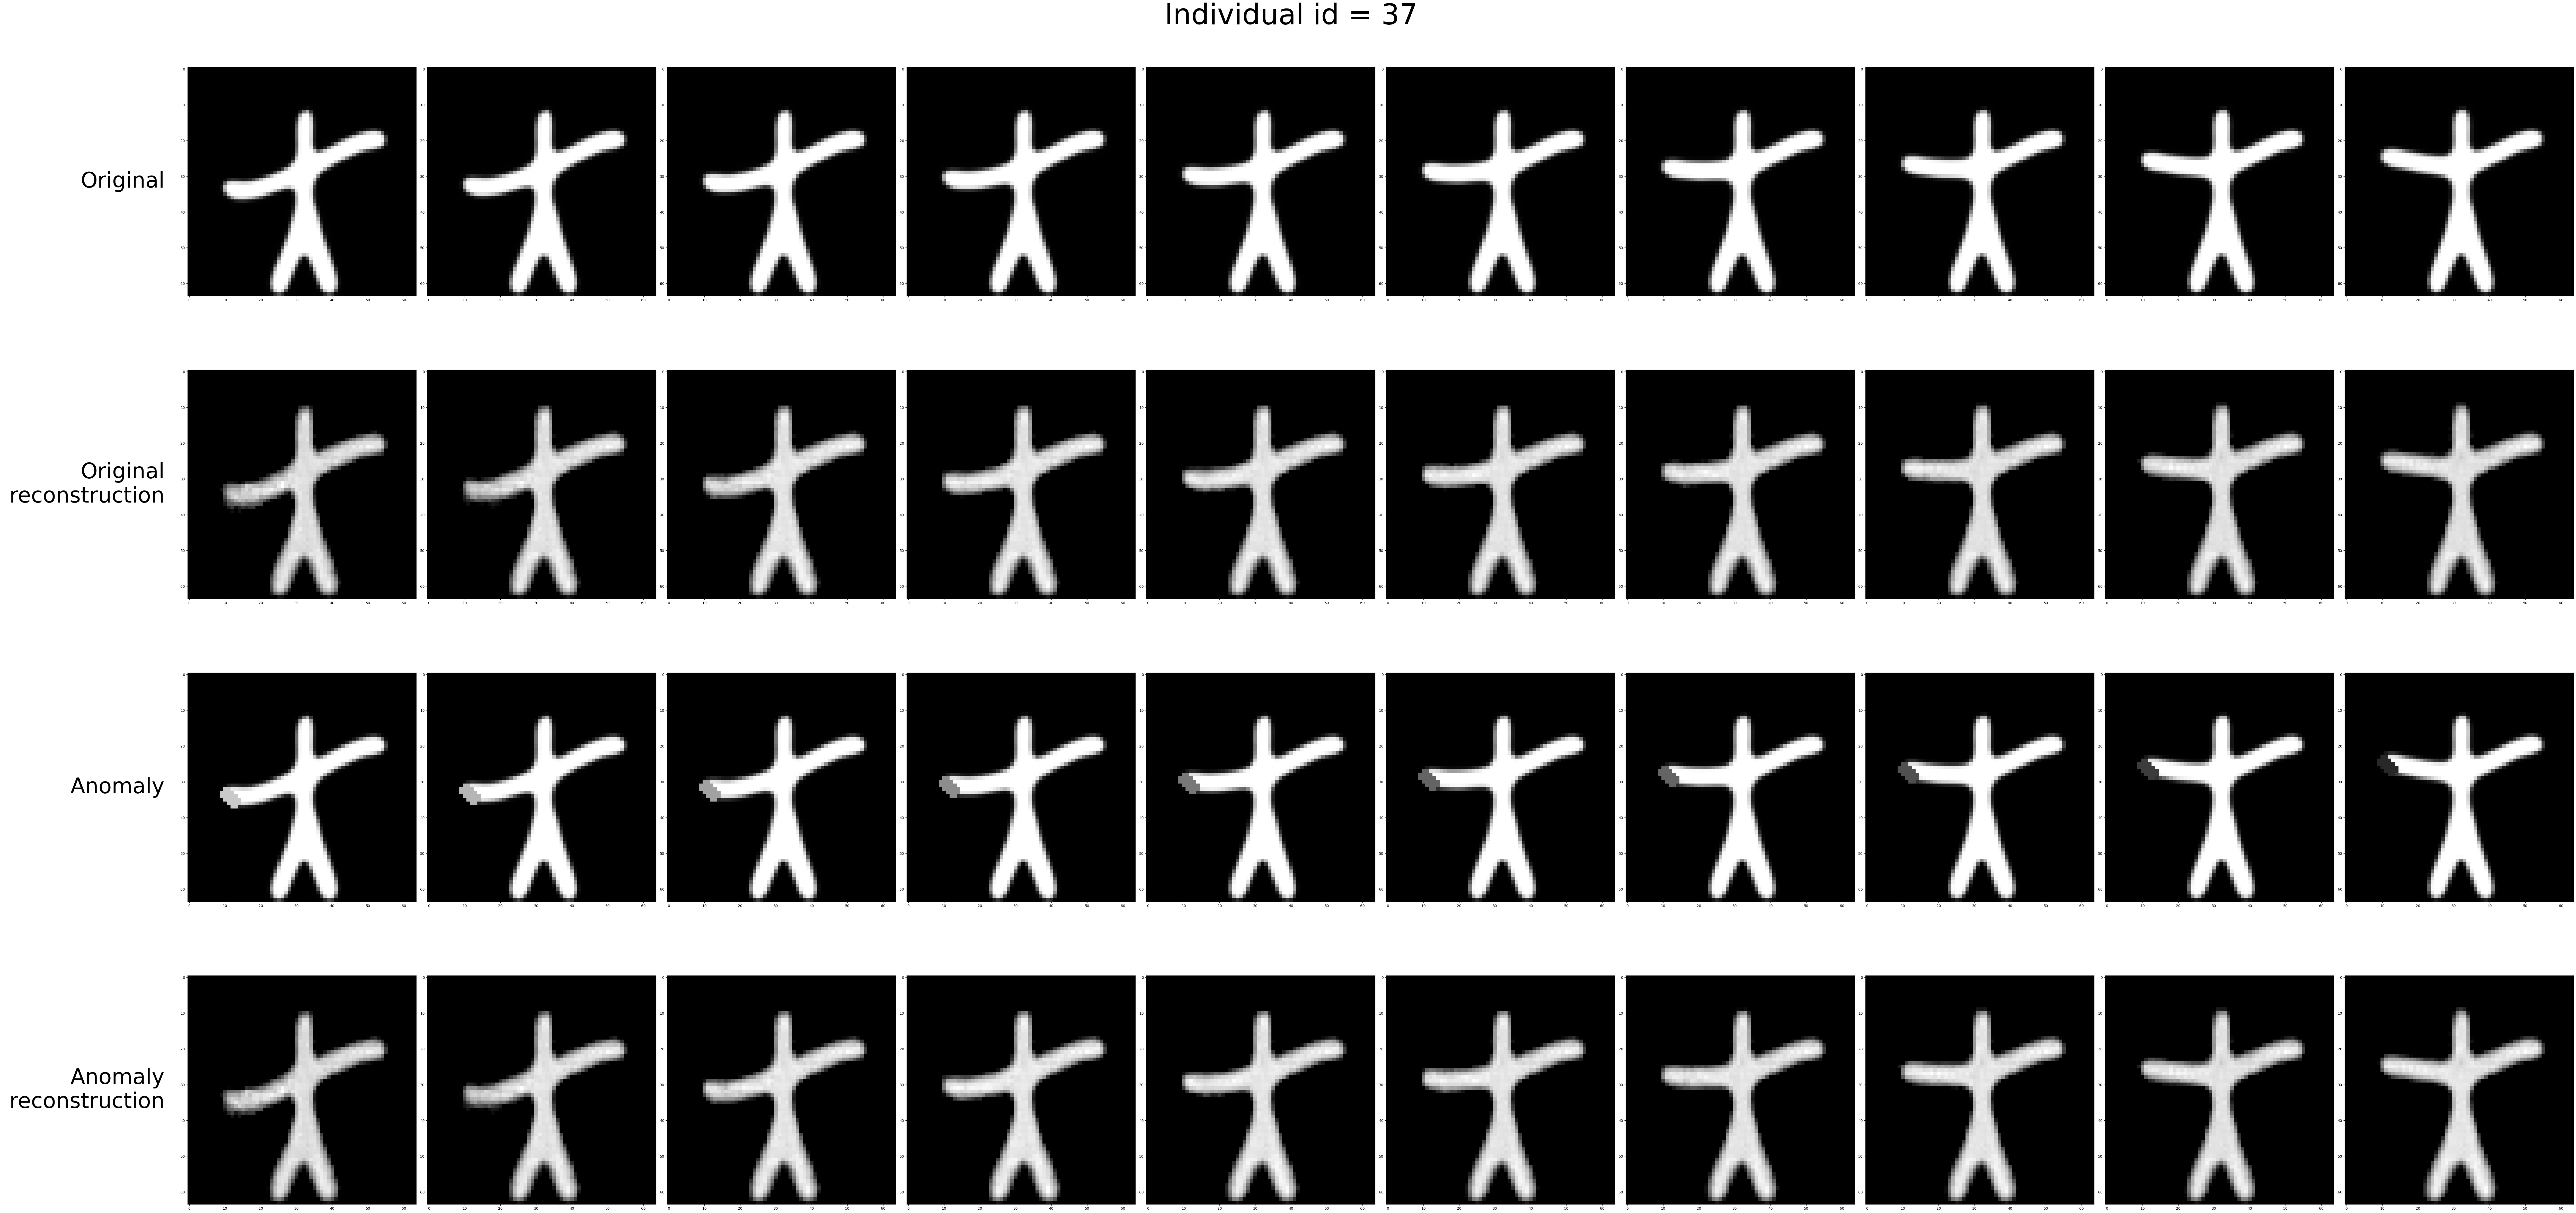

<Figure size 640x480 with 0 Axes>

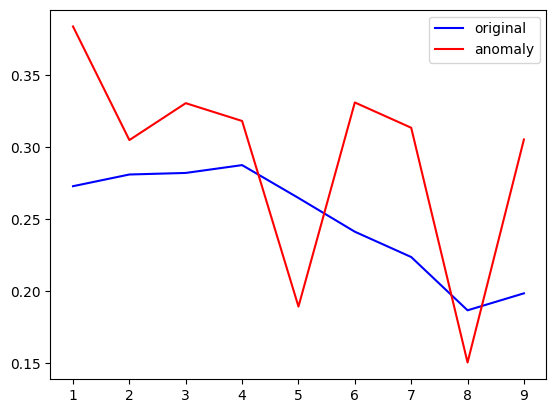

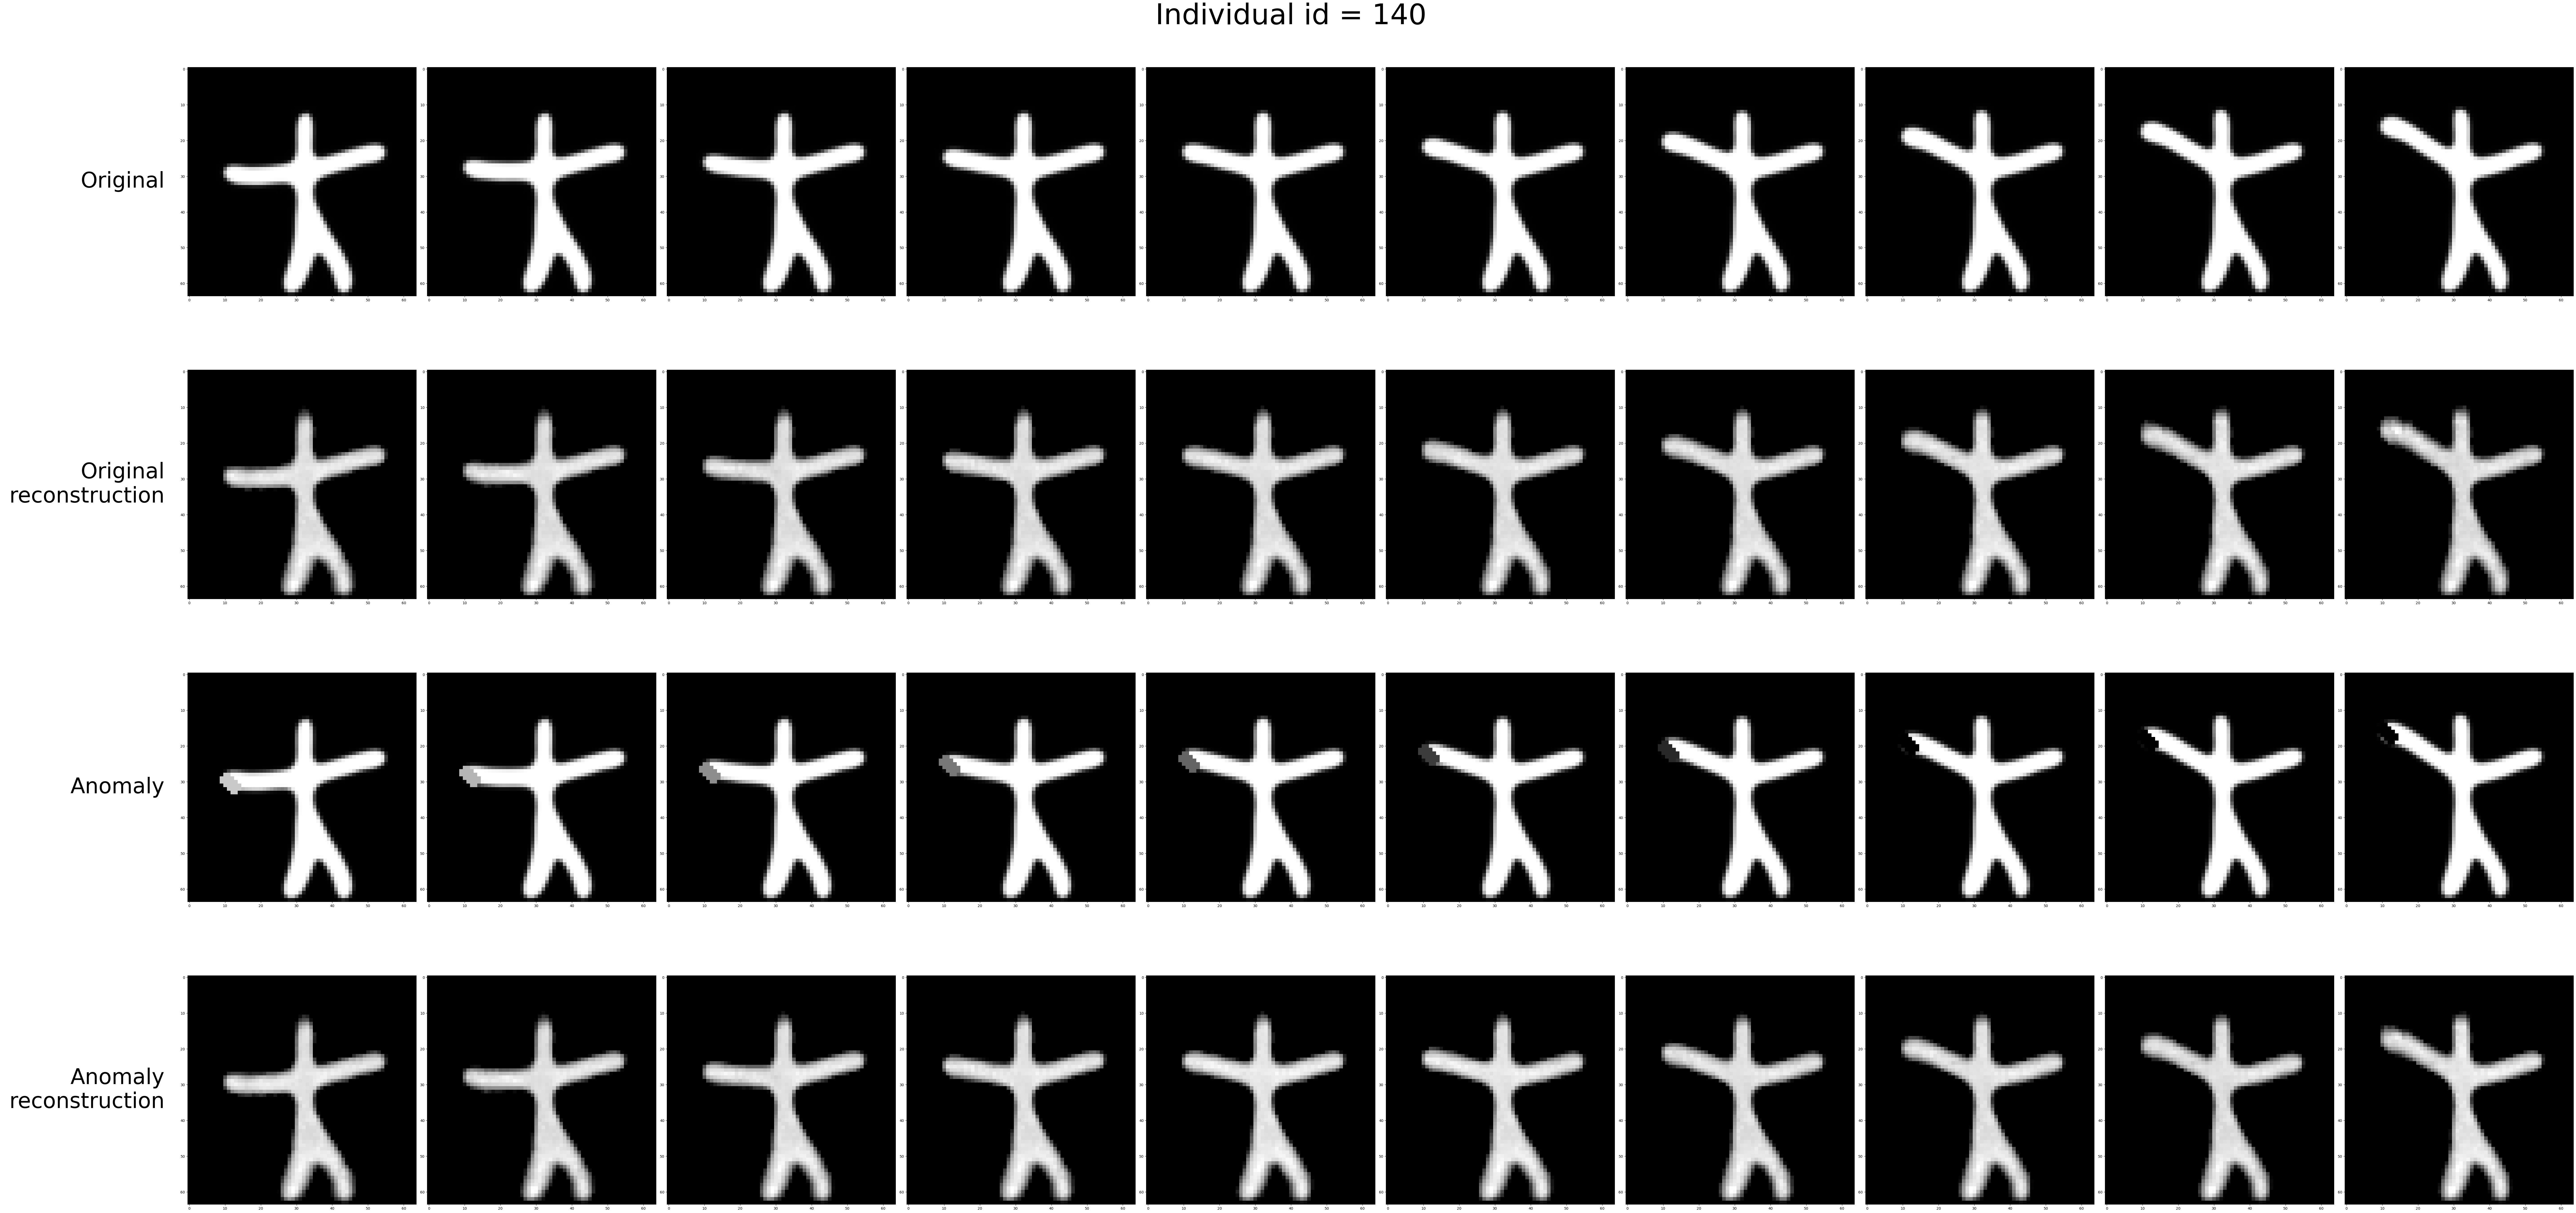

<Figure size 640x480 with 0 Axes>

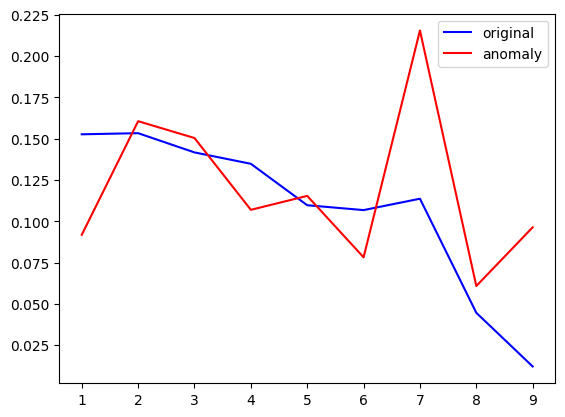

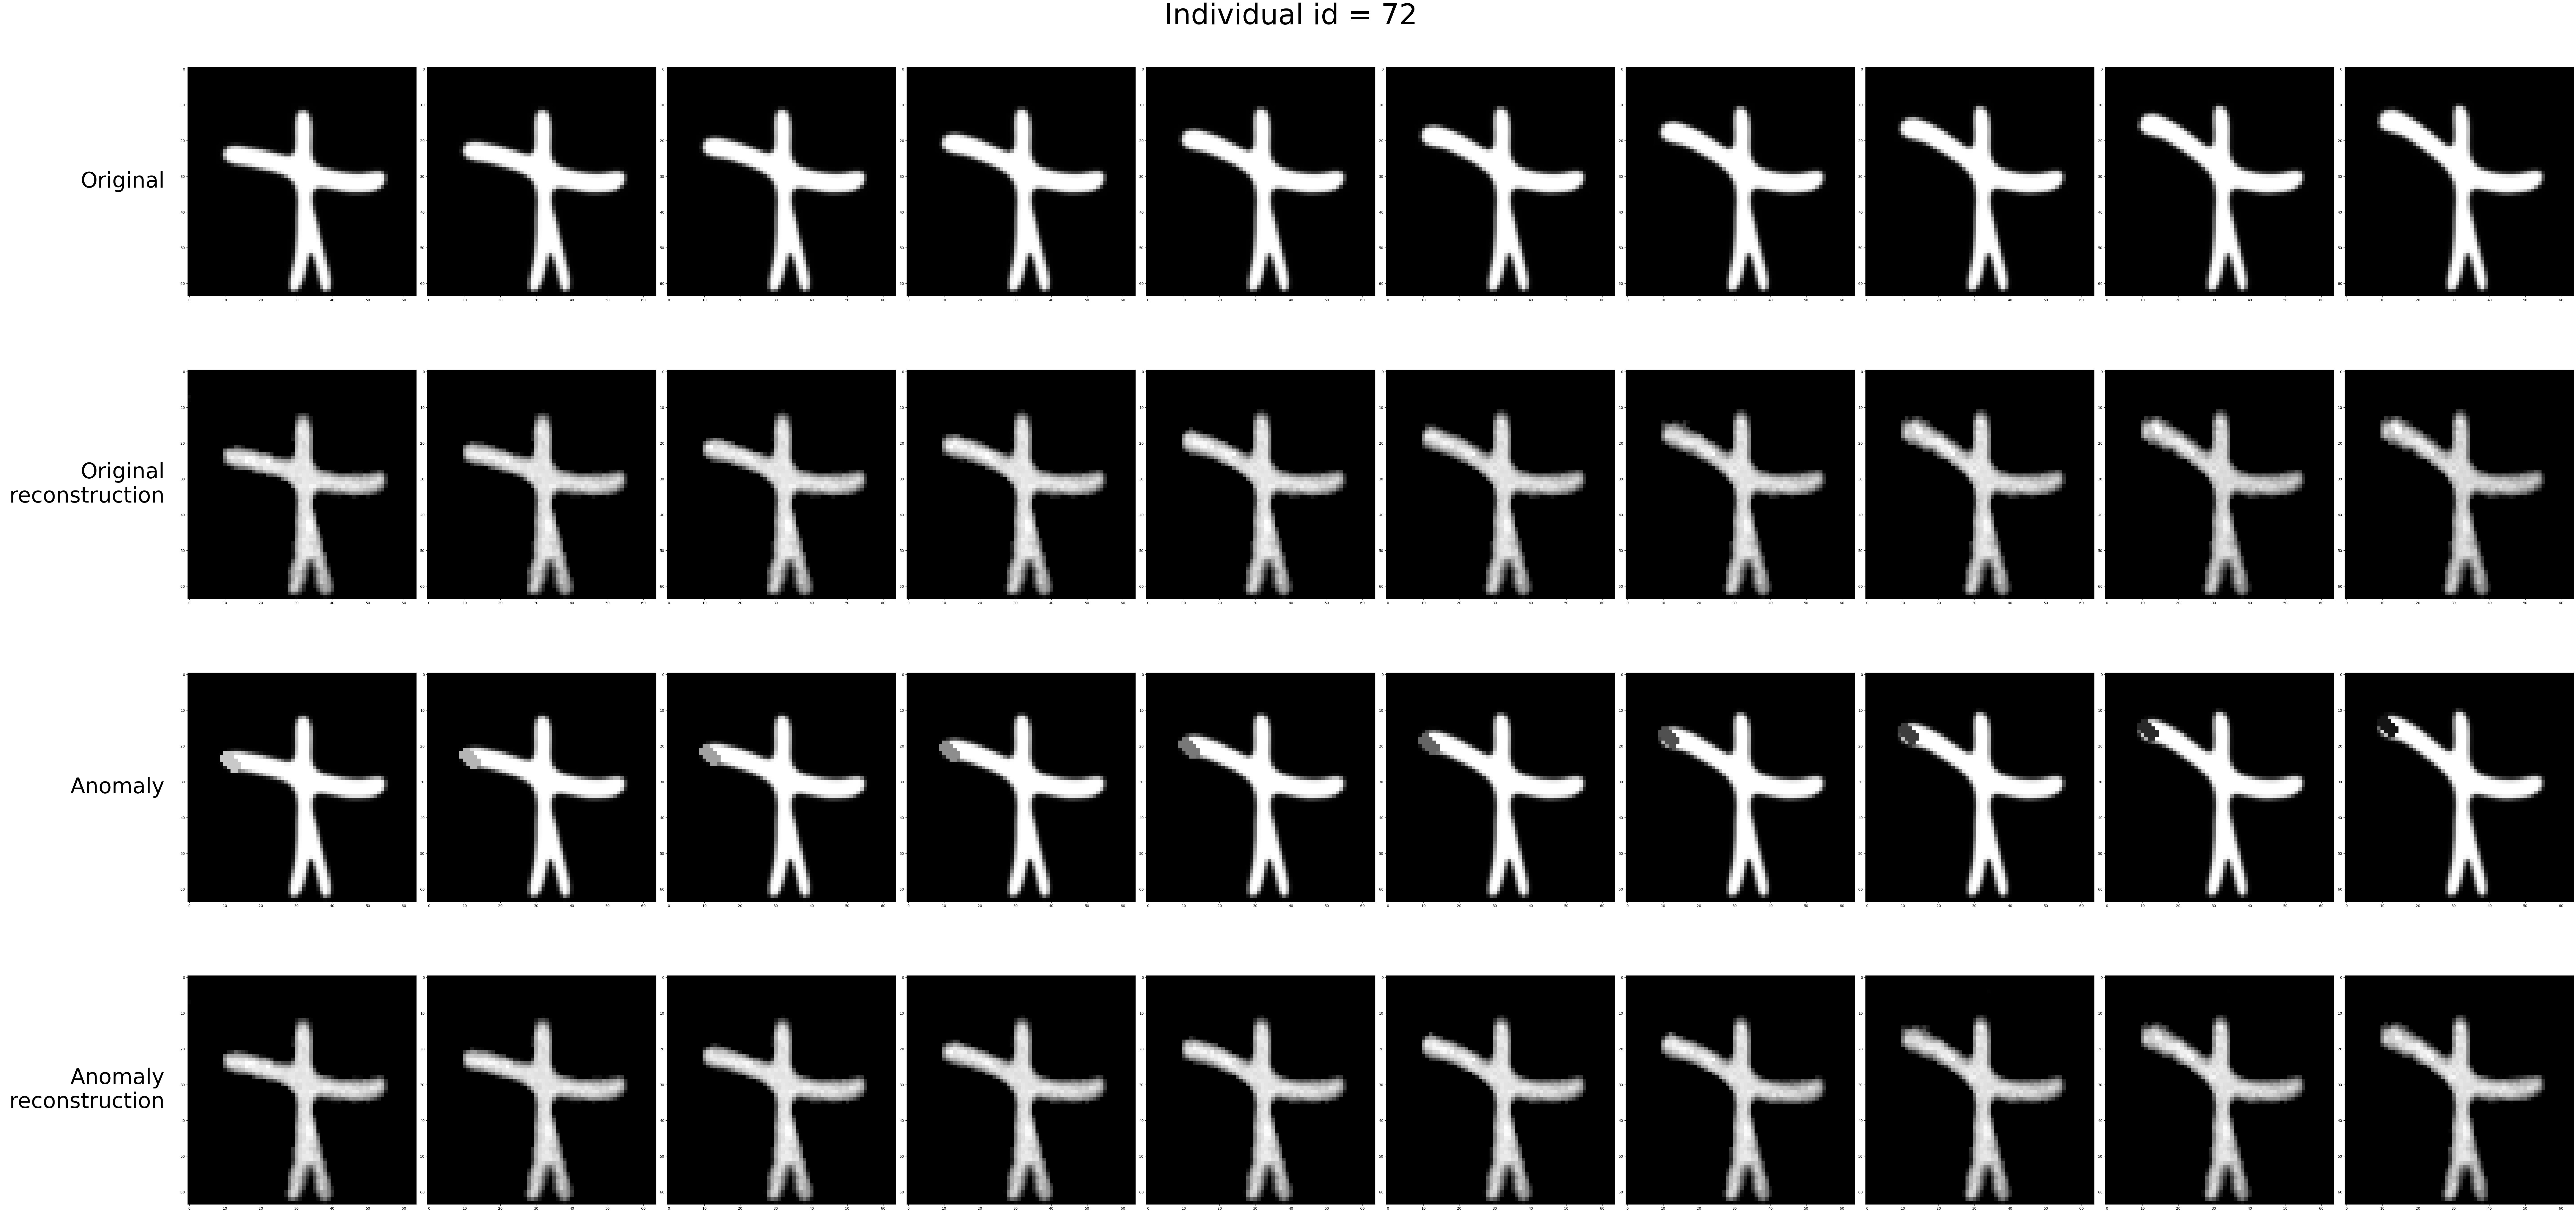

<Figure size 640x480 with 0 Axes>

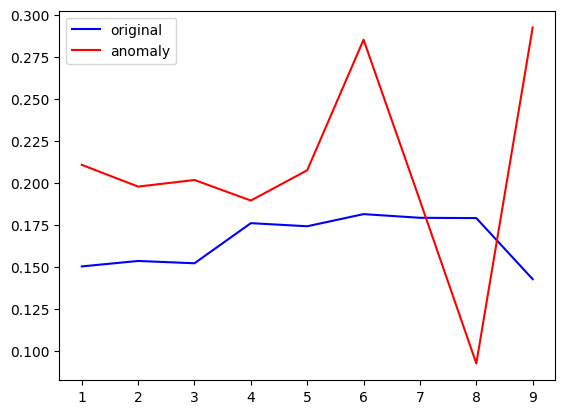

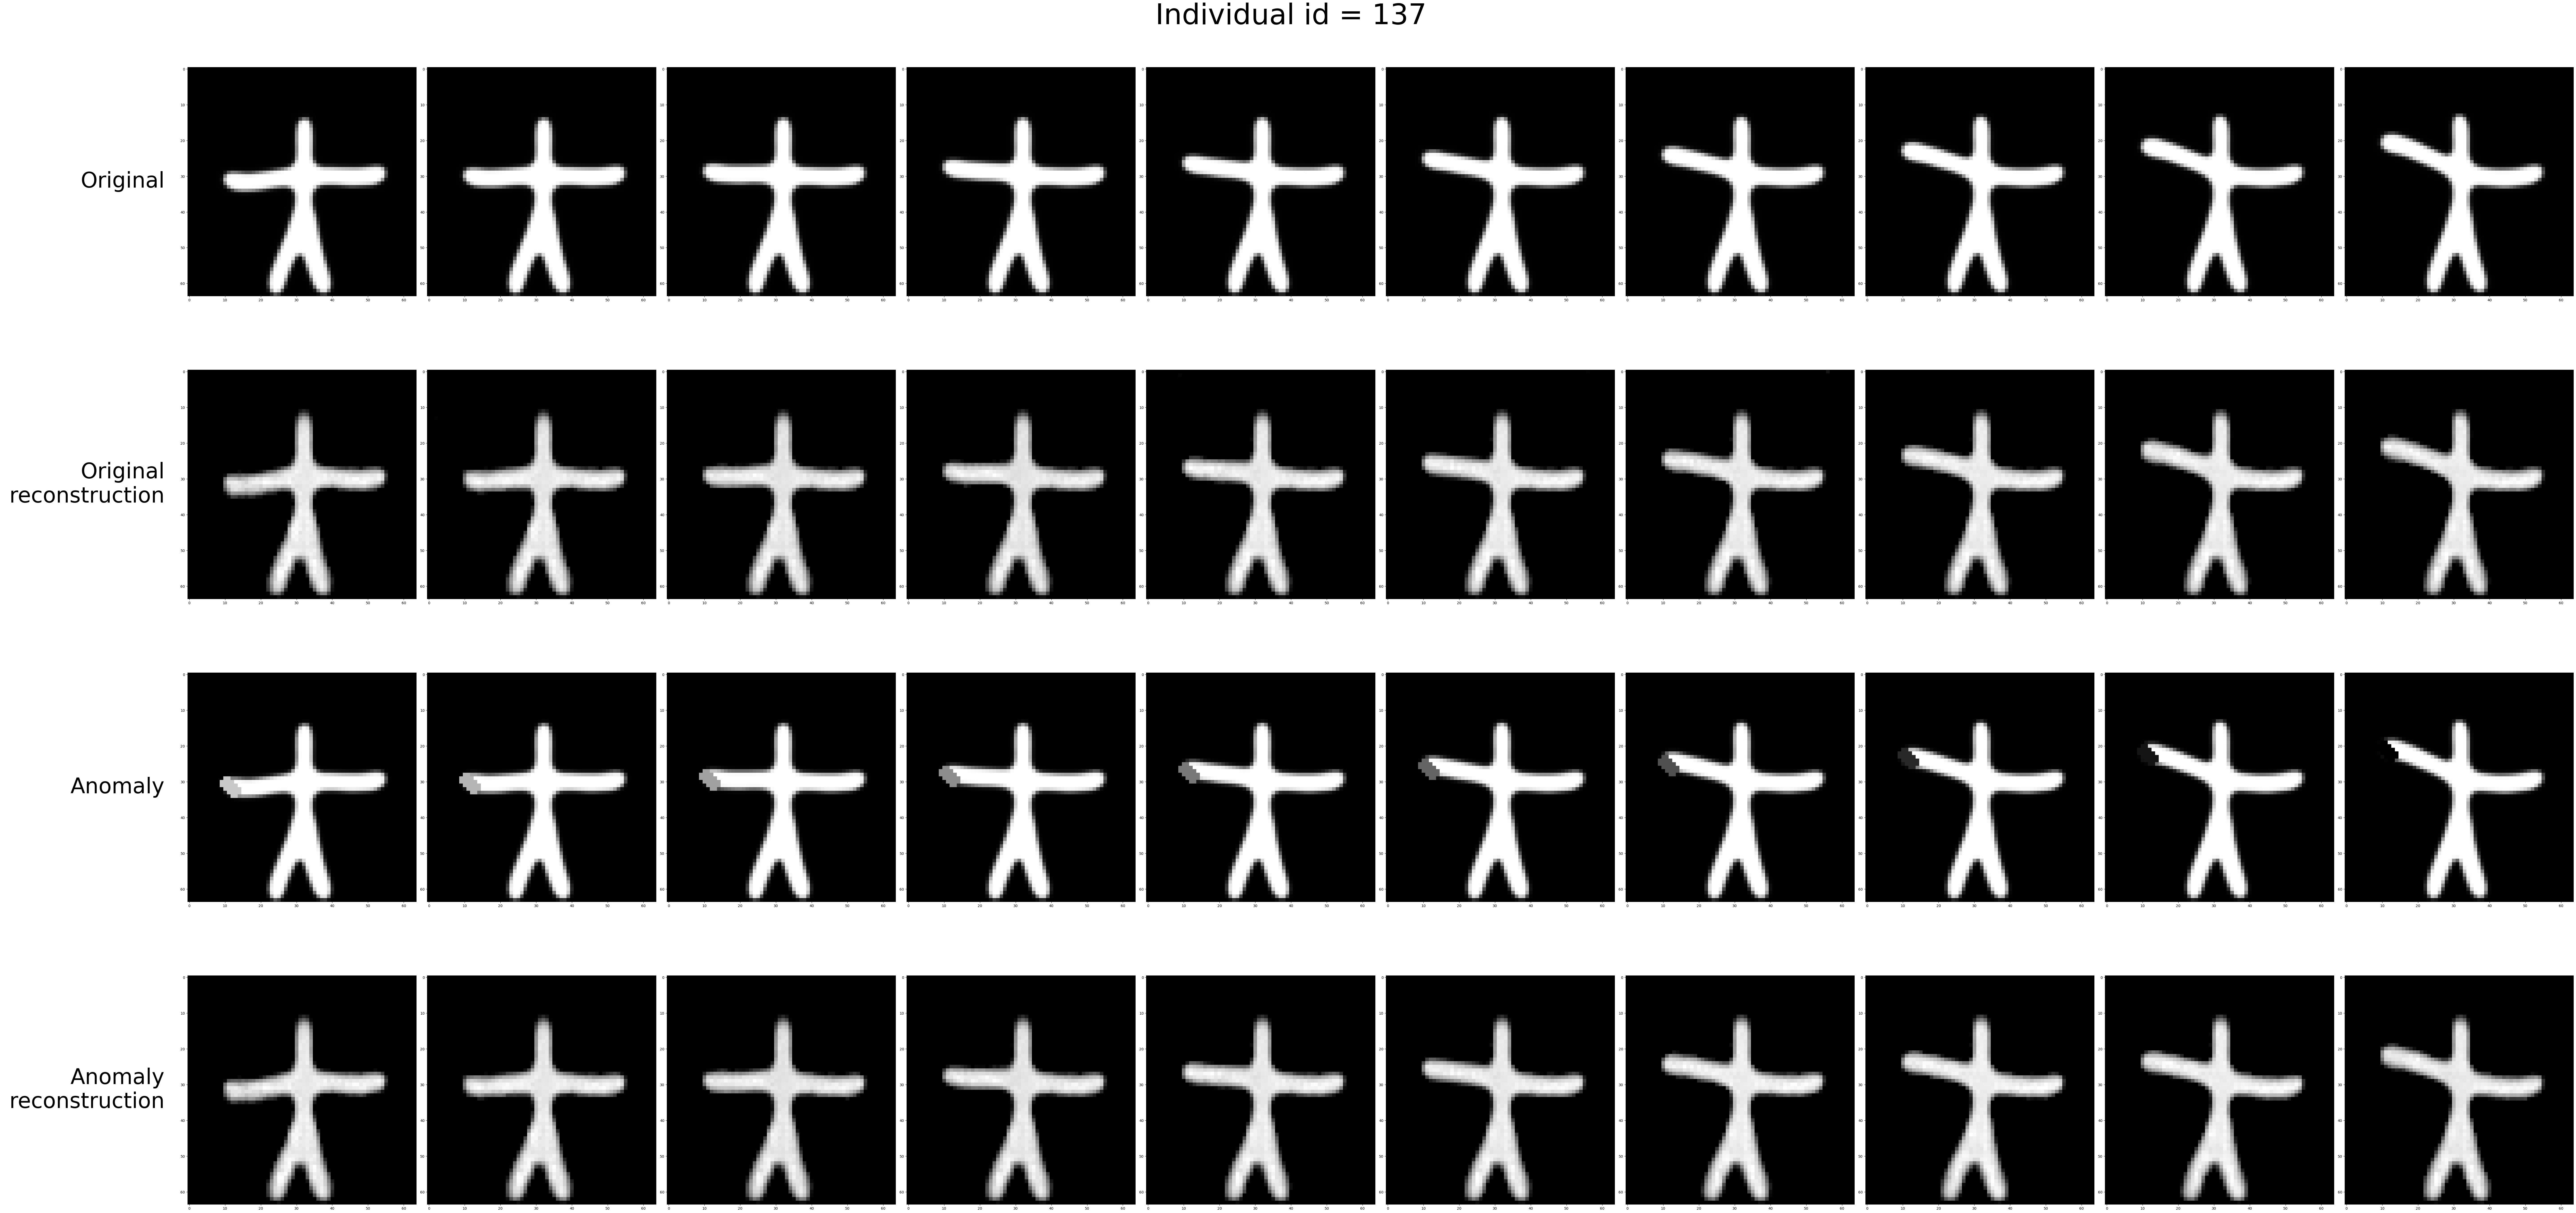

<Figure size 640x480 with 0 Axes>

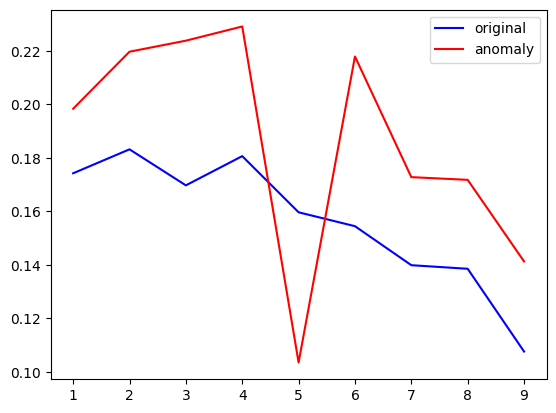

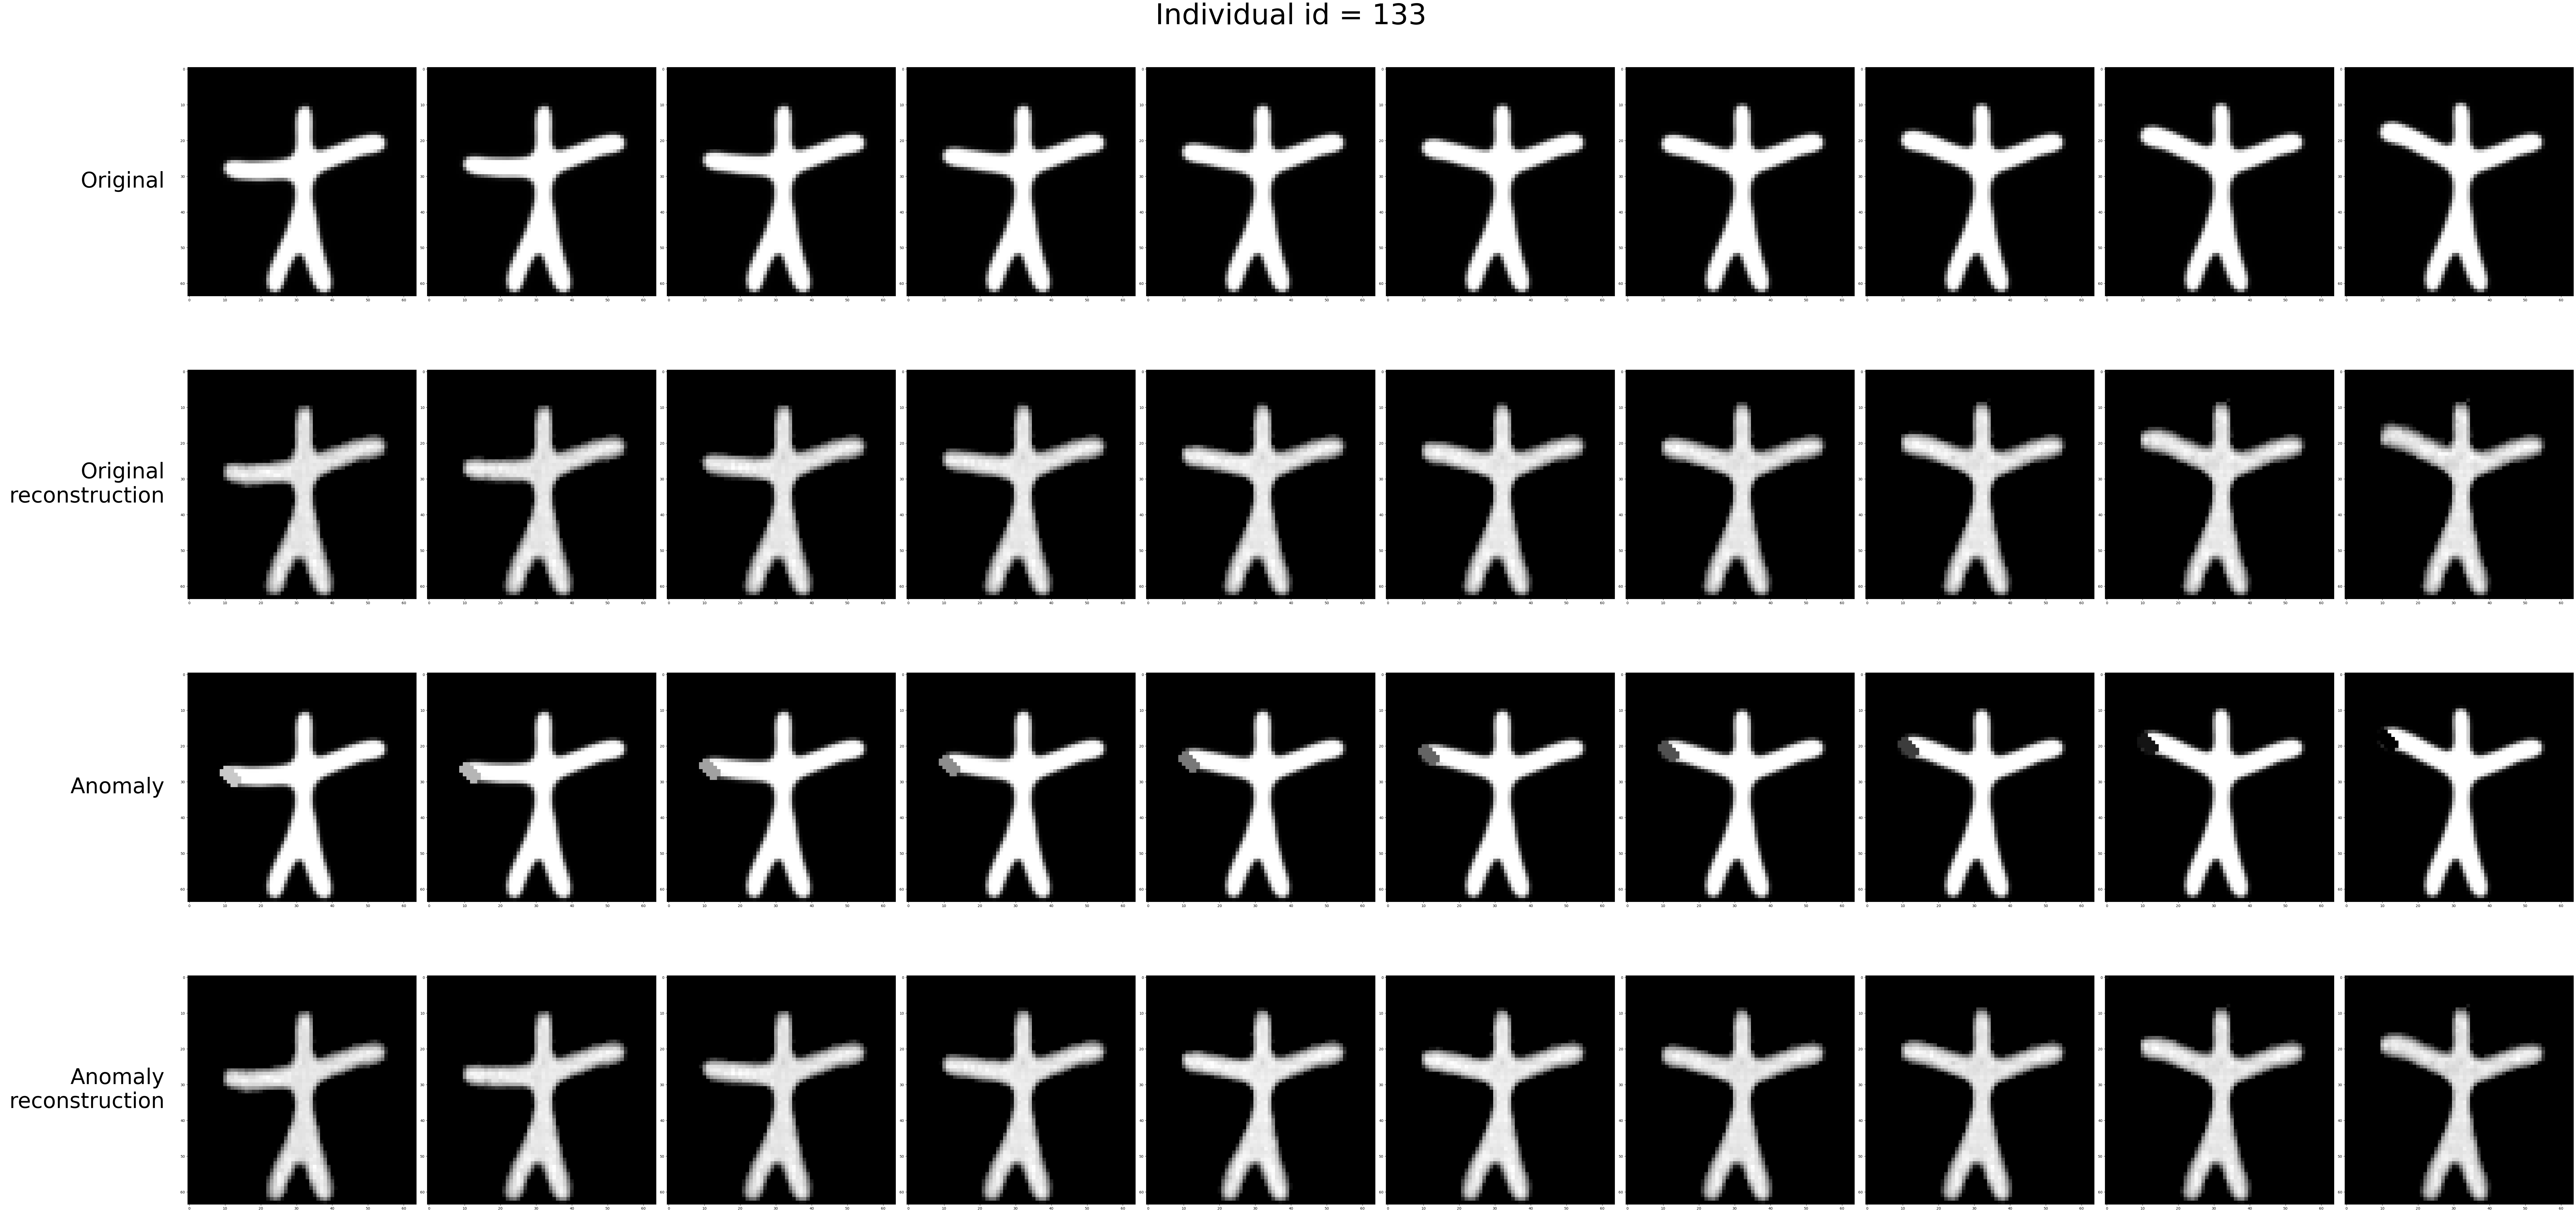

<Figure size 640x480 with 0 Axes>

In [ ]:
VAE_model_path = f"saved_models_2D/best_fold_CVAE2D_4_5.pth"
LVAE_model_path = f"saved_models_2D/best_fold_CVAE2D_4_5_100_200.pth2"
LVAE_estimator_path = f"saved_models_2Dbest_fold_longitudinal_estimator_params_CVAE2D_4_5_100_200.json2"


data_csv_path = "data_csv/starmen_test_set.csv"
dataset_test = LongitudinalDataset2D(data_csv_path)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=longitudinal_collate_2D, num_workers=round(os.cpu_count()/4))

anomaly_type = "darker_line"
data_anomaly_csv_path = f"data_csv/anomaly_{anomaly_type}_starmen_dataset.csv"
dataset_anomaly = LongitudinalDataset2D(data_anomaly_csv_path)
dataloader_anomaly = DataLoader(dataset_anomaly, batch_size=1, shuffle=False, collate_fn=longitudinal_collate_2D, num_workers=round(os.cpu_count()/4))

model = CVAE2D_ORIGINAL(4)
model.gamma = 100
model.beta = 5
model.load_state_dict(torch.load(VAE_model_path, map_location='cpu'))
model.to(device)
model.eval()
model.training = False

longitudinal_estimator = Leaspy.load(LVAE_estimator_path)

encodings_original_array = np.zeros((len(dataset_test), 10, 4))
encodings_anomaly_array = np.zeros((len(dataset_test), 10, 4))
n_subject = 0

image_original_array = np.zeros((len(dataset_test), 10, 64, 64))
image_original_reconstructed_array = np.zeros((len(dataset_test), 10, 64, 64))
image_anomaly_array = np.zeros((len(dataset_test), 10, 64, 64))
image_anomaly_reconstructed_array = np.zeros((len(dataset_test), 10, 64, 64))
ages_array = np.zeros((len(dataset_test), 10))

for data in dataloader_test:
    subject_id = data[2][0]
    ages_array[n_subject, :] = ages_list[subject_id*10: subject_id*10+10]
    images_original = data[0].to(device)
    images_anomaly = dataset_anomaly.get_images_from_id(subject_id)[0].reshape((10,1,64,64)).to(device)

    image_original_array[n_subject] = images_original.detach().numpy().reshape((10,64,64))
    image_anomaly_array[n_subject] = images_anomaly.detach().numpy().reshape((10,64,64))

    mus_original_LVAE, logvars_original_LVAE, reconstructed_original, _ = model(images_original)
    mus_anomaly_LVAE, logvars_original_LVAE, reconstructed_anomaly, _ = model(images_anomaly)
    
    for i in range(10):
        encodings_original_array[n_subject, i, :] = mus_original_LVAE[i].detach().numpy()
        encodings_anomaly_array[n_subject, i, :] = mus_anomaly_LVAE[i].detach().numpy()

        image_original_reconstructed_array[n_subject, i] = reconstructed_original[i].detach().numpy()
        image_anomaly_reconstructed_array[n_subject, i] = reconstructed_anomaly[i].detach().numpy()

    n_subject += 1


difference_original_norm = np.zeros((len(dataset_test), 9))
difference_anomaly_norm = np.zeros((len(dataset_test), 9))
for i in range(len(dataset_test)):
    ages_diff = ages_array[i, 1:] - ages_array[i, :-1]
    for j in range(9):
        difference_original_norm[i, j] = np.linalg.norm(encodings_original_array[i, j] - encodings_original_array[i, j+1], ord=1)
        difference_anomaly_norm[i, j] = np.linalg.norm(encodings_anomaly_array[i, j] - encodings_anomaly_array[i, j+1], ord=1)
    difference_original_norm[i, :] = difference_original_norm[i, :] * ages_diff
    difference_anomaly_norm[i, :] = difference_anomaly_norm[i, :] * ages_diff


np.random.seed(1)
random_id = np.random.choice(len(dataset_test), size=5)
for id in random_id:
    fig, ax = plt.subplots()
    ax.plot([i for i in range(1, 10)], difference_original_norm[id, :], color="blue", label="original")
    ax.plot([i for i in range(1, 10)], difference_anomaly_norm[id, :], color="red", label="anomaly")
    ax.legend()
    if show_fig:
        plt.show()
    else:
        fig.savefig(f"visu/{id}_trajectory_norm_diff_{anomaly_type}.pdf")
    plt.close(fig)
    plot_figures(image_original_array[id], image_original_reconstructed_array[id], image_anomaly_array[id], image_anomaly_reconstructed_array[id], id, anomaly_type, show_fig)


# Visualise latent variable difference

In [27]:
def plot_figures2(original_image, reconstructed_original_LVAE, gc_image, gc_reconstructed_LVAE, dl_image, dl_reconstructed_LVAE, id, save_fig=True):
    """
    We enter this function when an anomaly is detected.
    The function will plot the image and save it in a pdf file.
    """

    fig_width = original_image.shape[0] * 10
    fig_height = 60  # Adjust as needed
    f, axarr = plt.subplots(6, 10, figsize=(fig_width, fig_height))
    for i in range(original_image.shape[0]):
        axarr[0, i].imshow(original_image[i, :, :], cmap="gray")
        axarr[1, i].imshow(reconstructed_original_LVAE[i, :, :], cmap="gray")
        axarr[2, i].imshow(gc_image[i, :, :], cmap="gray")
        axarr[3, i].imshow(gc_reconstructed_LVAE[i, :, :], cmap="gray")
        axarr[4, i].imshow(dl_image[i, :, :], cmap="gray")
        axarr[5, i].imshow(dl_reconstructed_LVAE[i, :, :], cmap="gray")

        # axarr[0, i].set_title(f"LVAE={detection_vector_LVAE[i]}", fontsize=50)
    
    # Row labels
    row_labels = ["Original", "Original\n reconstruction", "Growing_circle (GC)", "GC reconstruction", "Darker_line (DL)", "DL reconstruction"]
    for row in range(6):
        # Add label to the first column of each row, closer and vertically centered
        axarr[row, 0].annotate(row_labels[row],
                            xy=(-0.1, 0.5),  # Slightly to the left, centered vertically
                            xycoords='axes fraction',
                            ha='right',
                            va='center',
                            fontsize=60)

    f.suptitle(f'Individual id = {id}', fontsize=80)
    plt.tight_layout()
    if save_fig:
        plt.savefig(f"./{id}_plot_figures.pdf")
    else:
        plt.show()        
    plt.clf()
    return 

In [ ]:
VAE_model_path = f"saved_models_2D/best_fold_CVAE2D_4_5.pth"
LVAE_model_path = f"saved_models_2D/best_fold_CVAE2D_4_5_100_200.pth2"
LVAE_estimator_path = f"saved_models_2Dbest_fold_longitudinal_estimator_params_CVAE2D_4_5_100_200.json2"

data_csv_path = "data_csv/starmen_test_set.csv"
dataset_test = LongitudinalDataset2D(data_csv_path)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=longitudinal_collate_2D, num_workers=round(os.cpu_count()/4))

anomaly_growing_circle = "growing_circle"
data_anomaly_growing_circle_csv_path = f"data_csv/anomaly_{anomaly_growing_circle}_starmen_dataset.csv"
dataset_anomaly_growing_circle = LongitudinalDataset2D(data_anomaly_growing_circle_csv_path)
dataloader_anomaly_growing_circle = DataLoader(dataset_anomaly_growing_circle, batch_size=1, shuffle=False, collate_fn=longitudinal_collate_2D, num_workers=round(os.cpu_count()/4))

anomaly_darker_line = "darker_line"
data_anomaly_darker_line_csv_path = f"data_csv/anomaly_{anomaly_darker_line}_starmen_dataset.csv"
dataset_anomaly_darker_line = LongitudinalDataset2D(data_anomaly_darker_line_csv_path)
dataloader_anomaly_darker_line = DataLoader(dataset_anomaly_darker_line, batch_size=1, shuffle=False, collate_fn=longitudinal_collate_2D, num_workers=round(os.cpu_count()/4))


model = CVAE2D_ORIGINAL(4)
model.gamma = 100
model.beta = 5
model.load_state_dict(torch.load(LVAE_model_path, map_location='cpu'))
model.to(device)
model.eval()
model.training = False

longitudinal_estimator = Leaspy.load(LVAE_estimator_path)

list_id = dataset_test.list_patient_ids
n_random_subject = 5
np.random.seed(1)
random_ids = np.random.choice(list_id, size=n_random_subject, replace=False)

encodings_original_array = np.zeros((n_random_subject, 10, 4))
encodings_anomaly_growing_circle_array = np.zeros((n_random_subject, 10, 4))
encodings_anomaly_darker_line_array = np.zeros((n_random_subject, 10, 4))

image_original_array = np.zeros((n_random_subject, 10, 64, 64))
image_anomaly_growing_circle_array = np.zeros((n_random_subject, 10, 64, 64))
image_anomaly_darker_line_array = np.zeros((n_random_subject, 10, 64, 64))

image_original_reconstructed_array = np.zeros((n_random_subject, 10, 64, 64))
image_anomaly_growing_circle_reconstructed_array = np.zeros((n_random_subject, 10, 64, 64))
image_anomaly_darker_line_reconstructed_array = np.zeros((n_random_subject, 10, 64, 64))

# ages_array = np.zeros((n_random_subject, 10))


n_subject = 0
for subject_id in random_ids:
    # # Get the age for current subject
    # ages_array[n_subject, :] = ages_list[subject_id*10: subject_id*10+10]
    
    # Get the tensor of images for the current subject
    images_original = dataset_test.get_images_from_id(subject_id)[0].reshape((10,1,64,64)).to(device)
    images_anomaly_growing_circle = dataset_anomaly_growing_circle.get_images_from_id(subject_id)[0].reshape((10,1,64,64)).to(device)
    images_anomaly_darker_line = dataset_anomaly_darker_line.get_images_from_id(subject_id)[0].reshape((10,1,64,64)).to(device)

    # Transform them into array for plots
    image_original_array[n_subject] = images_original.detach().numpy().reshape((10,64,64))
    image_anomaly_growing_circle_array[n_subject] = images_anomaly_growing_circle.detach().numpy().reshape((10,64,64))
    image_anomaly_darker_line_array[n_subject] = images_anomaly_darker_line.detach().numpy().reshape((10,64,64))

    # Pass the image tensor in the LVAE, get the latent encodings and reconstructions
    mus_original_LVAE, logvars_original_LVAE, reconstructed_original, _ = model(images_original)
    mus_anomaly_growing_circle_LVAE, logvars_anomaly_growing_circle_LVAE, reconstructed_anomaly_growing_circle, _ = model(images_anomaly_growing_circle)
    mus_anomaly_darker_line_LVAE, logvars_anomaly_darker_line_LVAE, reconstructed_anomaly_darker_line, _ = model(images_anomaly_darker_line)
    
    # Store the encodings and images in numpy arrays for plots
    for i in range(10):
        encodings_original_array[n_subject, i, :] = mus_original_LVAE[i].detach().numpy()
        encodings_anomaly_growing_circle_array[n_subject, i, :] = mus_anomaly_growing_circle_LVAE[i].detach().numpy()
        encodings_anomaly_darker_line_array[n_subject, i, :] = mus_anomaly_darker_line_LVAE[i].detach().numpy()

        image_original_reconstructed_array[n_subject, i] = reconstructed_original[i].detach().numpy()
        image_anomaly_growing_circle_reconstructed_array[n_subject, i] = reconstructed_anomaly_growing_circle[i].detach().numpy()
        image_anomaly_darker_line_reconstructed_array[n_subject, i] = reconstructed_anomaly_darker_line[i].detach().numpy()

    n_subject += 1


timestamps = [i for i in range(1,11)]

for id in range(n_random_subject):
    # Create subplots
    fig, axes = plt.subplots(4, 1, figsize=(8, 10), sharex=True)
    # Plot each dimension in its own subplot
    for i in range(4):
        axes[i].plot(timestamps, encodings_original_array[id, :, i], color="blue", label="original")
        axes[i].plot(timestamps, encodings_anomaly_growing_circle_array[id, :, i], color="red", label="growing_circle")
        axes[i].plot(timestamps, encodings_anomaly_darker_line_array[id, :, i], color="green", label="darker_line")

        axes[i].set_ylabel(f'Dim {i+1}')
        axes[i].grid(True)
        axes[i].legend()
    
    axes[-1].set_xlabel('Time')
    fig.suptitle(f"Evolution of latent variable for subject {random_ids[id]}")
    plt.tight_layout()
    plt.savefig(f"./{random_ids[id]}_trajectory_latent.pdf")
    plt.close(fig)
    plot_figures2(image_original_array[id], image_original_reconstructed_array[id], 
                 image_anomaly_growing_circle_array[id], image_anomaly_growing_circle_reconstructed_array[id],
                 image_anomaly_darker_line_array[id], image_anomaly_darker_line_reconstructed_array[id], 
                 random_ids[id], save_fig=True)
    # plt.show()
    

<Figure size 10000x6000 with 0 Axes>

<Figure size 10000x6000 with 0 Axes>

<Figure size 10000x6000 with 0 Axes>

<Figure size 10000x6000 with 0 Axes>

<Figure size 10000x6000 with 0 Axes>

# Plotting pixel errors histogram

In [20]:
def plot_anomaly_bar(array_anomaly_detected, model_name, num_images, save_path):
    """
    This function will plot bars corresponding to the number of time the model detect
    an anomaly for the i-th image of a subject.
    """

    x = np.array([i for i in range(1, 11)])
    color = "tab:blue" if model_name=="VAE" else "tab:orange"

    fig, ax = plt.subplots()
    ax.bar(x, array_anomaly_detected/(num_images//10), color=color, edgecolor='black')
    ax.set_xlabel('Image')
    ax.set_ylabel('Count')
    ax.set_title(f'Mean number of anomalous pixels per timestamp')
    ax.set_xticks(x)
    ax.set_ylim(0, 500)
    plt.tight_layout()

    plt.savefig(save_path)
    plt.close(fig)
    return 

In [ ]:
with open("results_pixel_AD_growing_circle.json") as json_file:
    dict_growing_circle_AD = json.load(json_file)

with open("results_pixel_AD_darker_line.json") as json_file:
    dict_darker_line_AD = json.load(json_file)

plot_anomaly_bar(np.array(dict_growing_circle_AD["LVAE_pixel_anomaly_99"]), "LVAE", 2000, save_path="pixels_growing_circle_bar_plots.pdf")

plot_anomaly_bar(np.array(dict_darker_line_AD["LVAE_pixel_anomaly_99"]), "LVAE", 2000, save_path="pixels_darker_line_bar_plots.pdf")



# Patch visualisation

This image has 1747 patches


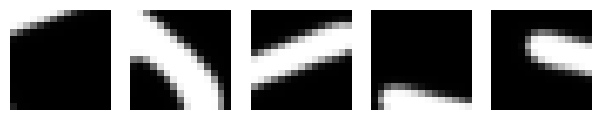

<Figure size 640x480 with 0 Axes>

In [4]:
# Load and visualise some patches

patient_id = 10
t = 0

patches_path = f"./data_starmen/images_patch/Starman__subject_s{patient_id}__tp_{t}_patches.npy"
patches = np.load(patches_path)
num_patches = patches.shape[0]
patch_to_visualise = 5

print(f"This image has {num_patches} patches")

random_patch_index = np.random.choice(num_patches, size=patch_to_visualise)


fig, ax = plt.subplots(1, 5, figsize=(patch_to_visualise* 1.5, 4))

for i in range(patch_to_visualise):
    ax[i].imshow(patches[random_patch_index[i]], cmap="gray")
    ax[i].axis("off")

plt.show()
plt.clf()



# **Test patch VAE**

## Plot VAE patch reconstruction

In [5]:
def plot_patch_comparison(patches_a, patches_b):
    n_patches = patches_a.shape[0]
    fig, axes = plt.subplots(2, n_patches, figsize=(n_patches* 1.5, 4))  # 2 rows, n columns
    # plt.subplots_adjust(wspace=0.1, hspace=0.1)

    for i in range(n_patches):
        # Upper row (patches_a)
        axes[0, i].imshow(patches_a[i], cmap='gray')
        axes[0, i].axis('off')

        # Bottom row (patches_b)
        axes[1, i].imshow(patches_b[i], cmap='gray')
        axes[1, i].axis('off')

    # Row labels
    row_labels = ["Original", "VAE"]
    for row in range(2):
        # Add label to the first column of each row, closer and vertically centered
        axes[row, 0].annotate(row_labels[row],
                            xy=(-0.1, 0.5),  # Slightly to the left, centered vertically
                            xycoords='axes fraction',
                            ha='right',
                            va='center',
                            fontsize=14)

    plt.tight_layout()
    plt.show(fig)
    plt.clf()

def plot_patch_comparison_VAEs(patches_original, patches_32, patches_64):
    n_patches = patches_original.shape[0]
    fig, axes = plt.subplots(3, n_patches, figsize=(n_patches* 1.5, 4))  # 2 rows, n columns
    # plt.subplots_adjust(wspace=0.1, hspace=0.1)

    for i in range(n_patches):
        # Upper row (patches_original)
        axes[0, i].imshow(patches_original[i], cmap='gray')
        axes[0, i].axis('off')

        # Middle row (patches_32)
        axes[1, i].imshow(patches_32[i], cmap='gray')
        axes[1, i].axis('off')

        # Bottom row (patches_64)
        axes[2, i].imshow(patches_64[i], cmap='gray')
        axes[2, i].axis('off')

    # Row labels
    row_labels = ["Original", "VAE (32)", "VAE (64)"]
    for row in range(3):
        # Add label to the first column of each row, closer and vertically centered
        axes[row, 0].annotate(row_labels[row],
                            xy=(-0.1, 0.5),  # Slightly to the left, centered vertically
                            xycoords='axes fraction',
                            ha='right',
                            va='center',
                            fontsize=14)

    plt.tight_layout()
    # plt.savefig("plots/patches_recon_m11.pdf")
    plt.show(fig)
    plt.clf()

Random patch number = [1029  726 1532  204 1380]


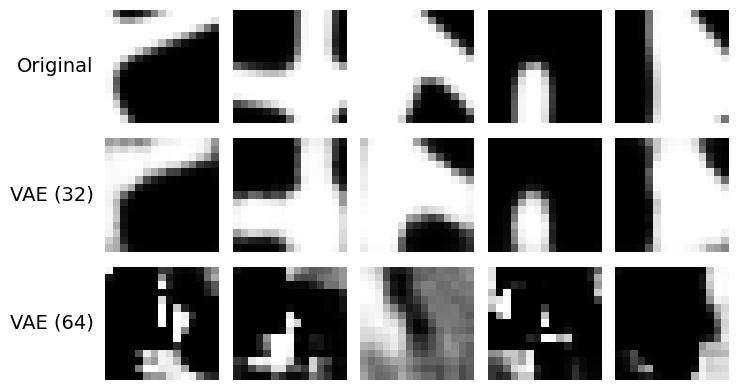

Random patch number = [1168   60 1002    2  510]


<Figure size 640x480 with 0 Axes>

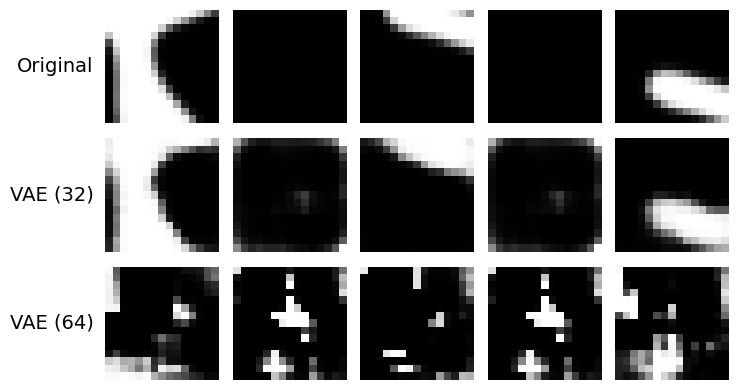

Random patch number = [   9   13 1421 1520 1004]


<Figure size 640x480 with 0 Axes>

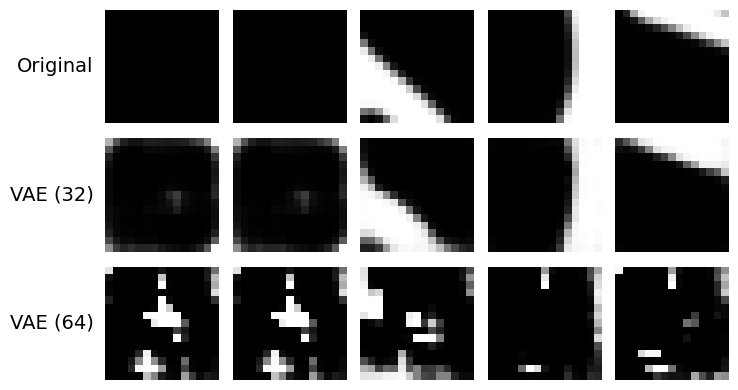

<Figure size 640x480 with 0 Axes>

In [22]:
from nnModels.CVAE2D_PATCH import CVAE2D_PATCH
from dataset.Dataset2D import Dataset2D, Dataset2D_patch
from dataset.LongitudinalDataset2D_patch import LongitudinalDataset2D_patch, longitudinal_collate_2D_patch
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import os

latent_dim = 32
beta = 0.5

# model_VAE_path = f"saved_models_2D/best_patch_fold_CVAE2D_{latent_dim}_{beta}.pth"
# model_VAE_path = f"saved_models_2D/VAE_patch_folds/CVAE2D_{latent_dim}_{beta}_fold_5.pth"





# model = CVAE2D_PATCH(latent_dim)
# model.load_state_dict(torch.load(model_VAE_path, map_location='cpu'))
# model = model.to(device)
# model.eval()
# model.training = False
# model.to(device)

model_VAE_path_32 = f"saved_models_2D/best_patch_fold_CVAE2D_32_{beta}.pth"
model_32 = CVAE2D_PATCH(32)
model_32.load_state_dict(torch.load(model_VAE_path_32, map_location='cpu'))
model_32 = model_32.to(device)
model_32.eval()
model_32.training = False
model_32.to(device)# model = CVAE2D_PATCH(latent_dim)

model_VAE_path_64 = f"saved_models_2D/best_patch_fold_CVAE2D_64_{beta}.pth"
model_64 = CVAE2D_PATCH(64)
model_64.load_state_dict(torch.load(model_VAE_path_64, map_location='cpu'))
model_64 = model_64.to(device)
model_64.eval()
model_64.training = False
model_64.to(device)




## VAE PART

# dataset_path = "./data_csv/starmen_dataset_patch.csv"
dataset_path = "./data_csv/starmen_patch_test_set.csv"

transformations = transforms.Compose([
            transforms.Lambda(lambda x: x.to(torch.float32))
            , transforms.Lambda(lambda x: 2*x - 1)
        ])


dataset = Dataset2D_patch(dataset_path, transform=transformations)
dataloader = DataLoader(dataset, 1, num_workers=int(os.cpu_count()/4), pin_memory=True, shuffle=False)


i = 0
for data in dataloader:
    data = data.reshape(-1, 1, 15, 15)
    output_32 = model_32(data)
    output_64 = model_64(data)
    i += 1
    if i > 3:
        break
    random_patches = np.random.choice(data.shape[0], size=5, replace=False)
    print("Random patch number =", random_patches)

    # plot_patch_comparison(data[random_patches, 0].detach(), output[2][random_patches, 0].detach())
    plot_patch_comparison_VAEs(data[random_patches, 0].detach(), ((output_32[2][random_patches, 0]+1)/2).detach(), ((output_64[2][random_patches, 0]+1)/2).detach())

## LVAE PART
# dataset = LongitudinalDataset2D_patch("./data_csv/train_patch_folds/starmen_patch_train_set_fold_0.csv")
# dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=int(os.cpu_count()/4), pin_memory=True, collate_fn=longitudinal_collate_2D_patch)

# for data in dataloader:
#     print(len(data))
#     patches = data[0]
#     print(patches.shape)
#     output = model(patches)
#     plt.imshow(output[2].detach().numpy()[0,0], cmap="gray")
#     plt.show()
#     break

# nice_patch = [653,  357,  912, 1804,  602]

## Longitudinal training stuff

In [17]:
def get_chunk(dataset, chunk_idx, chunk_size):
    start = chunk_idx * chunk_size
    end = min(start + chunk_size, len(dataset))
    return torch.utils.data.Subset(dataset, list(range(start, end)))

# Example usage
fold_index = [0,1,2,3,4,5,6]
folds_df_list = [pd.read_csv(f"data_csv/train_patch_folds/starmen_patch_train_set_fold_{i}.csv") for i in fold_index]
train_df = pd.concat([ folds_df_list[i] for i in range(len(fold_index))], ignore_index=True)
dataset = LongitudinalDataset2D(train_df)
chunk_size = int(0.1 * len(dataset))  # 10%
total_chunks = len(dataset) // chunk_size + (len(dataset) % chunk_size > 0)

for epoch in range(10):
    chunk_idx = epoch % total_chunks  # cycles through chunks
    subset = get_chunk(dataset, chunk_idx, chunk_size)
    loader = DataLoader(subset, batch_size=64, shuffle=True)

print(len(dataset))
print(chunk_size)

875
87


In [ ]:
2000*2500


True

## Anomaly Detection with patches

In [6]:
def extract_centered_patches(image, patch_size=15):
    """
    This functions takes as input an image (numpy array) and the patch size.
    It returns the patches centered in every pixel not in the border and the coordinates of its center.
    """
    assert patch_size % 2 == 1, "Patch size must be odd."
    h, w = image.shape[:2]
    half = patch_size // 2

    patches = []
    centers = []

    for i in range(half, h - half):
        for j in range(half, w - half):
            patch = image[i - half:i + half + 1, j - half:j + half + 1]  # (h, w)
            patches.append(patch)
            centers.append((i, j))

    return np.array(patches), centers


def get_patch_centers_containing_pixel(pixel_x, pixel_y, image_size=64, patch_size=15):
    half = patch_size // 2
    min_center = half
    max_center = image_size - half - 1  # inclusive range

    x_start = max(pixel_x - half, min_center)
    x_end = min(pixel_x + half, max_center)
    y_start = max(pixel_y - half, min_center)
    y_end = min(pixel_y + half, max_center)

    centers = [(i, j) for i in range(x_start, x_end + 1)
                      for j in range(y_start, y_end + 1)]
    return centers


def get_patch_centers(patch_size=15, image_shape=(64,64)):
    """
    This function takes the patch size and the image shape and returns all the patch's centers.
    """
    assert patch_size % 2 == 1, "Patch size must be odd."
    h, w = image_shape[:2]
    half = patch_size // 2

    # Valid center coordinates (avoid borders)
    y_coords = np.arange(half, h - half)
    x_coords = np.arange(half, w - half)

    # Create grid of centers
    yy, xx = np.meshgrid(y_coords, x_coords, indexing='ij')
    centers = np.stack([yy.ravel(), xx.ravel()], axis=1)

    return centers.tolist()  # shape: (N, 2)

def pad_anomaly_array(anomaly_array, patch_size=15):
    """
    This function will pad the anomaly score array to shape (64x64) i.e. starmen image shape
    """
    # Compute padding
    pad_size = patch_size // 2

    # Pad with zeros (or change to np.nan if you prefer)
    padded_anomaly_array = np.pad(anomaly_array,
                    ((pad_size, pad_size), (pad_size, pad_size)),
                    mode='constant', constant_values=0.0)

    return padded_anomaly_array

def image_reconstruction_error_patch(reconstructed, input):
    recon_error = torch.sum((reconstructed - input) ** 2, dim=(1, 2, 3))
    return recon_error


def compute_pixel_ano_score(patch_loss, pixel_count, patch_size=15):
    if len(patch_loss.shape) < 2: 
        patch_loss = patch_loss.reshape((64,64))

    # This array is used to store the anomaly score of one pixel (anomaly score to choose)
    pixel_anomaly_score = np.zeros((64,64))

    # This array is used to store the number of time a pixel is involved in a patch (to do mean)
    # pixel_count = np.zeros((64,64))

    # This array is used to compute the right number of time a pixel is involved in a patch
    pixel_relevant_count = np.ones((50,50))
    pixel_relevant_count = pad_anomaly_array(pixel_relevant_count)

    # This array was obtained previously after putting the image in the model and getting the loss/anomaly score
    patch_loss = np.array(patch_loss).reshape((50,50))
    pad_patch_loss_array = pad_anomaly_array(patch_loss)


    for i in range(64):
        for j in range(64):
            # Build the window to get all the anomaly patches
            top = max(i - 15//2, 0)
            bottom = min(i + 15//2 + 1, 64)
            left = max(j - 15//2, 0)
            right = min(j + 15//2 + 1, 64)

            pixel_count[i,j] += np.sum(pixel_relevant_count[top:bottom , left:right])
            pixel_anomaly_score[i,j] += np.sum(pad_patch_loss_array[top:bottom , left:right])     # Just compute sum
            # pixel_anomaly_score[i,j] +=  np.sum(pad_patch_loss_array[top:bottom , left:right]) / ( (bottom-top)*(right-left) ) # If compute mean
            
    return pixel_anomaly_score


In [17]:
# Anomaly detection with patches

transformations = transforms.Compose([
            transforms.Lambda(lambda x: x.to(torch.float32))
            , transforms.Lambda(lambda x: 2*x - 1)
        ])
transformations_inv = transforms.Compose([transforms.Lambda(lambda x: (x+1)/2)])


latent_dim = 32
beta = 0.5

model_VAE_path_32 = f"saved_models_2D/best_patch_fold_CVAE2D_32_{beta}.pth"
model_32 = CVAE2D_PATCH(32)
model_32.load_state_dict(torch.load(model_VAE_path_32, map_location='cpu'))
model_32 = model_32.to(device)
model_32.eval()
model_32.training = False
model_32.to(device)

model_VAE_path_64 = f"saved_models_2D/best_patch_fold_CVAE2D_64_{beta}.pth"
model_64 = CVAE2D_PATCH(64)
model_64.load_state_dict(torch.load(model_VAE_path_64, map_location='cpu'))
model_64 = model_64.to(device)
model_64.eval()
model_64.training = False
model_64.to(device)

# Load threshold
thresholds_path = "data_csv/threshold_json/anomaly_threshold_patch_image_32_0.5.json"
with open(thresholds_path) as json_file:
        threshold_dict = json.load(json_file)

VAE_threshold_95 = threshold_dict["VAE_threshold_95"]
print("VAE_threshold_95 =", VAE_threshold_95)
VAE_threshold_99 = threshold_dict["VAE_threshold_99"]

# Prepare dataset and dataloader
anomaly_csv_path = "data_csv/anomaly_growing_circle_starmen_dataset_patch.csv"
dataset_test = LongitudinalDataset2D_patch(anomaly_csv_path, transform=transformations)
dataloader_test = DataLoader(dataset_test, batch_size=1, collate_fn=longitudinal_collate_2D_patch, shuffle=False) # batch_size = number of images


# centers_list = get_patch_centers()  # Use as global variable

patch_loss = []

s = 0

# First part of AD, getting the losses/anomaly score 
with torch.no_grad():
    for data in dataloader_test:
        random_patch_id = np.random.choice(2500, size=5)

        id = data[2][0]
        
        patches = data[0]
        patches = patches.to(device)
        print(torch.sum(patches > 1))
        break
        
        reconstructed_patches_32 = model_32(patches)[2]
        reconstructed_patches_64 = model_64(patches)[2]
        
        patches = patches.reshape((10, 2500, 1, 15, 15))
        reconstructed_patches_32 = reconstructed_patches_32.reshape((10, 2500, 1, 15, 15))
        reconstructed_patches_64 = reconstructed_patches_64.reshape((10, 2500, 1, 15, 15))

        for t in range(1,10):
            new_loss_32 = image_reconstruction_error_patch(reconstructed_patches_32[t], patches[t])
            new_loss_64 = image_reconstruction_error_patch(reconstructed_patches_64[t], patches[t])

            patches = transformations_inv(patches)
            reconstructed_patreconstructed_patches_32 = transformations_inv(reconstructed_patches_32)
            reconstructed_patreconstructed_patches_64 = transformations_inv(reconstructed_patches_64)


        plot_patch_comparison_VAEs(patches[t, random_patch_id, 0], reconstructed_patches_32[t, random_patch_id, 0], reconstructed_patches_64[t, random_patch_id, 0])

        s += 1
        if s > 5:
             break



VAE_threshold_95 = 12.684406709670998
tensor(1706377)


In [85]:
def compute_pixel_counting():
    """
    This function returns a numpy array where the element i,j gives the number of patches containing that pixel
    """
    
    pixel_relevant_count = np.ones((50,50))
    pixel_relevant_count = pad_anomaly_array(pixel_relevant_count)
    pixel_count = np.zeros((64,64))
    for i in range(64):
        for j in range(64):
            # Build the window to get all the anomaly patches
            top = max(i - 15//2, 0)
            bottom = min(i + 15//2 + 1, 64)
            left = max(j - 15//2, 0)
            right = min(j + 15//2 + 1, 64)

            pixel_count[i,j] += np.sum(pixel_relevant_count[top:bottom , left:right])
    
    return pixel_count

pixel_counting = compute_pixel_counting()

def patch_to_image(patch_array):
    """
    This function will take 
    """
    half = 7
    image = np.zeros((64,64))
    patch_num = 0
    for i in range(half, 64-half):
        for j in range(half, 64-half):
            top = max(i - 15//2, 0)
            bottom = min(i + 15//2 + 1, 64)
            left = max(j - 15//2, 0)
            right = min(j + 15//2 + 1, 64)

            image[top:bottom, left:right] += patch_array[patch_num]
            patch_num += 1

    return image/pixel_counting


test_patches = np.load("./data_starmen/images_patch/Starman__subject_s0__tp_0_patches.npy")
print(test_patches.shape)
recon_image = patch_to_image(test_patches)

plt.imshow(recon_image, cmap="gray")
plt.show()



NameError: name 'pad_anomaly_array' is not defined

# Try PCA

Number of subject = 200
Shape encodings anomaly = (2000, 4)
Shape encodings original = (2000, 4)


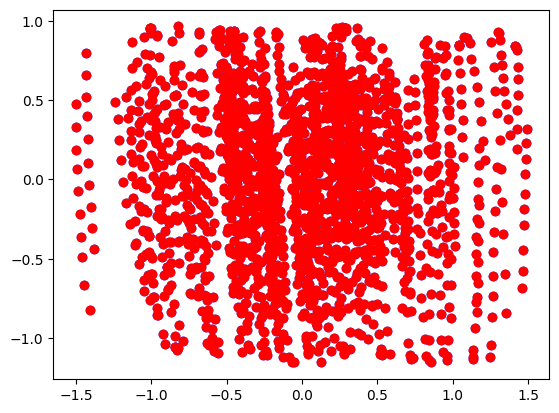

In [9]:
# Try PCA for visualisation
from sklearn.decomposition import PCA

device = "cuda" if torch.cuda.is_available() else "cpu"

data_csv_path = "data_csv/starmen_test_set.csv"
dataset_test = LongitudinalDataset2D(data_csv_path)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=longitudinal_collate_2D, num_workers=round(os.cpu_count()/4))

anomaly_type = "growing_circle"
data_anomaly_csv_path = f"data_csv/anomaly_{anomaly_type}_starmen_dataset.csv"
dataset_anomaly = LongitudinalDataset2D(data_anomaly_csv_path)
dataloader_anomaly = DataLoader(dataset_anomaly, batch_size=1, shuffle=False, collate_fn=longitudinal_collate_2D, num_workers=round(os.cpu_count()/4))

model = CVAE2D_ORIGINAL(4)
model.gamma = 100
model.beta = 5
model.load_state_dict(torch.load(LVAE_model_path, map_location='cpu'))
model.to(device)
model.eval()
model.training = False

longitudinal_estimator = Leaspy.load(LVAE_estimator_path)

encodings_anomaly_list = []
encodings_original_list = []

n_subject = 0
for data in dataloader_test:
    n_subject += 1

    # Get anomalous images and compute encodings
    images_anomaly = data[0].to(device)
    subject_id = data[2][0]
    mus_anomaly, logvars_anomaly, _, _ = model(images_anomaly)

    # Get original images and compute encodings
    images_original, _ = dataset_test.get_images_from_id(subject_id)
    mus_original, logvars_original, _, _ = model(images_original.reshape((10,1,64,64)))

    for i in range(10):
        encodings_anomaly_list.append(mus_anomaly[i].detach())
        encodings_original_list.append(mus_original[i].detach())


encodings_anomaly_array = np.array(encodings_anomaly_list)
encodings_original_array = np.array(encodings_original_list)
n_images = encodings_anomaly_array.shape[0]
print("Number of subject =", n_subject)
print("Shape encodings anomaly =", encodings_anomaly_array.shape)
print("Shape encodings original =", encodings_original_array.shape)

norm_list = np.zeros(9)
for i in range(n_images):
    timestamp = i%9
    norm_list[timestamp] += np.linalg.norm(encodings_anomaly_array[i,:] - encodings_original_array[i,:])

pca = PCA(n_components=2)
transformed_original_array = pca.fit_transform(encodings_original_array)
transformed_anomaly_array = pca.transform(encodings_anomaly_array)

plt.scatter(transformed_original_array[:, 0], transformed_original_array[:,1], color="blue", label="original")
plt.scatter(transformed_anomaly_array[:, 0], transformed_anomaly_array[:,1], color="red", label="anomaly")
plt.show()

In [ ]:
plt.scatter(transformed_original_array[:, 0], transformed_original_array[:,1], color="blue", label="original")
# plt.scatter(transformed_anomaly_array[:, 0], transformed_anomaly_array[:,1], color="red", label="anomaly")
plt.show()